# Perform sFC connectivity on either seeds or ROIs

In [2]:
import os
import sys
from glob import glob
import numpy as np
# from nipype.algorithms.confounds import TSNR
import cv2
import scipy
from scipy.io import loadmat
import nibabel as nib
import random
from nilearn import plotting
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import plotly.express as px
import plotly.graph_objects as go
import pickle 

from nilearn.signal import clean
from scipy.stats import kstest, ttest_ind, ttest_rel, \
ttest_1samp, normaltest, wilcoxon, chisquare, bootstrap, iqr, ks_2samp, shapiro
from nilearn.image import clean_img
from scikit_posthocs import posthoc_tukey

import plotly.io as pio
pio.kaleido.scope.chromium_args = tuple([arg for arg in pio.kaleido.scope.chromium_args if arg != "--disable-dev-shm-usage"])

import pingouin as pg
import pandas as pd
from random import randrange

from statsmodels.stats.multitest import multipletests

sys.path.append('../scripts')
from sFC_classes_v4 import *

In [3]:
server = True

In [4]:
if server:
    parentpath = "/media/miplab-nas2/Data2"
else:
    parentpath = "/Volumes/Data2"

In [5]:
data_path = os.path.join(parentpath, 'SpinalCord','Spinal_fMRI_Lumbar')

# Denoising comparison 

Options:

0) Only motion corrected images (baseline)
1) CSF only (1 regressor)\
2) MOCO params (2 regressors)\
3) CompCor (5 regressors)\
4) CompCor + Moco (7 regressors) \
5) Cardiac (8 regressors)\
6) Respiratory (8 regressors)\
7) PNM : card+resp+combinations (32 regressors)\
8) PNM + CSF (33 regressors)\
9) PNM + Moco (34 regressors)\
10) PNM + CSF + Moco (35 regressors)\
11) All: PNM + CSF + CompCor + Moco (40 regressors) \


Total to consider 11 + baseline (matrices will be 12)


In [6]:
def get_mfmri_den_details(option):
    # return name of the file to load and degrees of freedom
    if option == 0:
        return "mfmri_st_corr", 0
    elif option == 1:
        return "mfmri_st_corr_denoised_csf_csfonly", 1
    elif option == 2:
        return "mfmri_st_corr_denoised_moco", 2
    elif option == 3:
        return "mfmri_st_corr_denoised_cc", 5
    elif option == 4:
        return "mfmri_st_corr_denoised_moco_cc", 7
    elif option == 5:
        return "mfmri_st_corr_denoised_pnm_cardonly", 8
    elif option == 6:
        return "mfmri_st_corr_denoised_pnm_responly", 8
    elif option == 7:
        return "mfmri_st_corr_denoised_pnm", 32
    elif option == 8:
        return "mfmri_st_corr_denoised_csf_pnm", 33
    elif option == 9:
        return "mfmri_st_corr_denoised_pnm_moco", 34
    elif option == 10:
        return "mfmri_st_corr_denoised_csf_pnm_moco", 35
    elif option == 11:
        return "mfmri_st_corr_denoised_csf_pnm_moco_cc", 40

In [7]:
def get_mfmri_den_details_nostc(option):
    # return name of the file to load and degrees of freedom
    if option == 0:
        return "mfmri", 0
    elif option == 1:
        return "mfmri_denoised_csf_csfonly", 1
    elif option == 2:
        return "mfmri_denoised_moco", 2
    elif option == 3:
        return "mfmri_denoised_cc", 5
    elif option == 4:
        return "mfmri_denoised_moco_cc", 7
    elif option == 5:
        return "mfmri_denoised_pnm_cardonly", 8
    elif option == 6:
        return "mfmri_denoised_pnm_responly", 8
    elif option == 7:
        return "mfmri_denoised_pnm", 32
    elif option == 8:
        return "mfmri_denoised_csf_pnm", 33
    elif option == 9:
        return "mfmri_denoised_pnm_moco", 34
    elif option == 10:
        return "mfmri_denoised_pnm_csf_moco", 35   ## invert csf and pnm
    elif option == 11:
        return "mfmri_denoised_csf_pnm_moco_cc", 40

In [8]:
options_to_consider = np.arange(12)

In [9]:
options_to_consider

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

### Select option:

In [10]:
option = 1

In [11]:
def get_option_foldername(opt):
    
    ''
    input_den_image, _ = get_mfmri_den_details(opt) 
    preproc='_'.join(input_den_image.split('_')[4:])
    if opt == 0:
        preproc = "baseline"
        
    return f"{opt}_{preproc}_stc"

In [12]:
def get_option_foldername_nostc(opt):
    
    ''
    input_den_image, _ = get_mfmri_den_details_nostc(opt) 
    preproc='_'.join(input_den_image.split('_')[2:])
    if opt == 0:
        preproc = "baseline"
        
    return f"{opt}_{preproc}"

In [13]:
for i in options_to_consider:
    print(get_option_foldername(i))

0_baseline_stc
1_csf_csfonly_stc
2_moco_stc
3_cc_stc
4_moco_cc_stc
5_pnm_cardonly_stc
6_pnm_responly_stc
7_pnm_stc
8_csf_pnm_stc
9_pnm_moco_stc
10_csf_pnm_moco_stc
11_csf_pnm_moco_cc_stc


In [14]:
def get_filename(opt,tempfilt):
    input_den_image, _ = get_mfmri_den_details(opt)
    preproc='_'.join(input_den_image.split('_')[2:])
    # add temp filter addition
    input_den_image += "_"+tempfilt
    if opt == 0:
        preproc = "baseline"
        input_den_image = input_den_image[:-(len(tempfilt)+1)] 
    return input_den_image

In [15]:
def get_filename_nostc(opt,tempfilt):
    input_den_image, _ = get_mfmri_den_details_nostc(opt)
    preproc='_'.join(input_den_image.split('_')[2:])
    # add temp filter addition
    input_den_image += "_"+tempfilt
    if opt == 0:
        preproc = "baseline"
        input_den_image = input_den_image[:-(len(tempfilt)+1)] 
    return input_den_image

In [16]:
for i in options_to_consider:
    print(get_option_foldername_nostc(i))

0_baseline
1_csf_csfonly
2_moco
3_cc
4_moco_cc
5_pnm_cardonly
6_pnm_responly
7_pnm
8_csf_pnm
9_pnm_moco
10_pnm_csf_moco
11_csf_pnm_moco_cc


# Average - ROIs

In [17]:
option = 10
method = "average"   # "average" (average signals -- 1st vestion), "slices" (corr per slice -- 2nd version)
auto = True    # If auto is True: template ROIs are used, 
               # if False: manual seeds
    
if auto:
    add = "ROIs"
else:
    add = "seeds"
    
tempfilt = "BP13"

input_den_image = get_filename(option, tempfilt)
out_name = get_option_foldername(option)
outfolderpath = f"PreProc-Comparison/{out_name}"

print(f"Input file: {input_den_image}")
print(f"Output folder: {out_name}")
print(f"Path: {outfolderpath}")

FC = sFCsorConnectivity(data_path, 
                        tempfilt=tempfilt,
                        out_folder=outfolderpath,
                        method=method,
                        auto=auto,
                        subIDs_to_exclude=["LU_AM","LU_LP","LU_RL","LU_VS"])
                        
                        # old : ["LU_AM","LU_AF","LU_MC","LU_MT","LU_AR","LU_LP","LU_RL","LU_VS", "LU_NK", "LU_IR","LU_NS"]

Input file: mfmri_st_corr_denoised_csf_pnm_moco_BP13
Output folder: 10_csf_pnm_moco_stc
Path: PreProc-Comparison/10_csf_pnm_moco_stc


In [17]:
len(FC.subjects_paths)

24

In [18]:
run_FC = False

In [19]:
if run_FC:
    mean_FC = FC.run_allsubs_parallel(fname=input_den_image)
else:
    mean_FC = np.load(os.path.join(data_path,outfolderpath,tempfilt, method, add, f'FC_ave_all_{add}_{method}.npy'))

In [20]:
mean_FC

array([[1.        , 0.08750216, 0.07114209, 0.05503908],
       [0.08750216, 1.        , 0.0682643 , 0.07443256],
       [0.07114209, 0.0682643 , 1.        , 0.03115819],
       [0.05503908, 0.07443256, 0.03115819, 1.        ]])

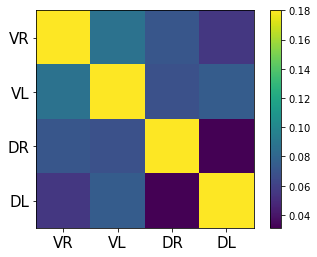

In [21]:
plt.imshow(mean_FC,vmax=0.18)
plt.xticks([0,1,2,3],["VR","VL","DR","DL"] , fontsize=15)
plt.yticks([0,1,2,3],["VR","VL","DR","DL"], fontsize=15)
plt.colorbar()
#plt.savefig("FCmatrix_pnmcsfmoco.pdf")

## Compared to no slice time corr

In [22]:
comparison_nostc = False

In [23]:
if comparison_nostc:
    # only run for 10
    option = 10
    method = "average"   # "average" (average signals -- 1st vestion), "slices" (corr per slice -- 2nd version)
    auto = False    # If auto is True: template ROIs are used, 
                   # if False: manual seeds

    if auto:
        add = "ROIs"
    else:
        add = "seeds"

    tempfilt = "BP13"

    input_den_image = get_filename_nostc(option, tempfilt)
    out_name = get_option_foldername_nostc(option)
    outfolderpath = f"PreProc-Comparison/{out_name}"

    print(f"Input file: {input_den_image}")
    print(f"Output folder: {out_name}")
    print(f"Path: {outfolderpath}")

    FC = sFCsorConnectivity(data_path, 
                            tempfilt=tempfilt,
                            out_folder=outfolderpath,
                            method=method,
                            auto=auto,
                            subIDs_to_exclude=["LU_AM","LU_LP","LU_RL","LU_VS"])
    run_FC = True
    if run_FC:
        mean_FC = FC.run_allsubs_parallel(fname=input_den_image)
    else:
        mean_FC = np.load(os.path.join(data_path,outfolderpath,tempfilt, method, add, f'FC_ave_all_{add}_{method}.npy'))
        
    print(mean_FC)
    plt.imshow(mean_FC,vmax=0.25)
    plt.colorbar()

# Slices - ROIs 

In [24]:
option = 10
method = "slices"   # "average" (average signals -- 1st vestion), "slices" (corr per slice -- 2nd version)
auto = True    # If auto is True: template ROIs are used, 
               # if False: manual seeds
    
if auto:
    add = "ROIs"
else:
    add = "seeds"
    
tempfilt = "BP13"

input_den_image = get_filename(option, tempfilt)
out_name = get_option_foldername(option)
outfolderpath = f"PreProc-Comparison/{out_name}"

print(f"Input file: {input_den_image}")
print(f"Output folder: {out_name}")
print(f"Path: {outfolderpath}")

FC = sFCsorConnectivity(data_path, 
                        tempfilt=tempfilt,
                        out_folder=outfolderpath,
                        method=method,
                        auto=auto,
                        subIDs_to_exclude=["LU_AM","LU_LP","LU_RL","LU_VS"])

Input file: mfmri_st_corr_denoised_csf_pnm_moco_BP13
Output folder: 10_csf_pnm_moco_stc
Path: PreProc-Comparison/10_csf_pnm_moco_stc


In [25]:
if run_FC:
    mean_FC = FC.run_allsubs_parallel(fname=input_den_image)
else:
    mean_FC = np.load(os.path.join(data_path,outfolderpath,tempfilt, method, add, f'FC_ave_all_{add}_{method}.npy'))

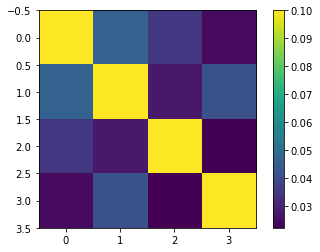

In [26]:
plt.imshow(mean_FC,vmax=0.1)
plt.colorbar()

#  Average - seeds 

In [18]:
option = 10
method = "average"   # "average" (average signals -- 1st vestion), "slices" (corr per slice -- 2nd version)
auto = False    # If auto is True: template ROIs are used, 
               # if False: manual seeds
    
if auto:
    add = "ROIs"
else:
    add = "seeds"
    
tempfilt = "BP13"

input_den_image = get_filename(option, tempfilt)
out_name = get_option_foldername(option)
outfolderpath = f"PreProc-Comparison/{out_name}"

print(f"Input file: {input_den_image}")
print(f"Output folder: {out_name}")
print(f"Path: {outfolderpath}")

FC = sFCsorConnectivity(data_path, 
                        tempfilt=tempfilt,
                        out_folder=outfolderpath,
                        method=method,
                        auto=auto,
                        subIDs_to_exclude=["LU_AM","LU_LP","LU_RL","LU_VS"])

Input file: mfmri_st_corr_denoised_csf_pnm_moco_BP13
Output folder: 10_csf_pnm_moco_stc
Path: PreProc-Comparison/10_csf_pnm_moco_stc


In [28]:
run_FC = False

In [29]:
if run_FC:
    mean_FC = FC.run_allsubs_parallel(fname=input_den_image)
else:
    mean_FC = np.load(os.path.join(data_path,outfolderpath,tempfilt, method, add, f'FC_ave_all_{add}_{method}.npy'))

In [30]:
len(FC.subjects_paths)

24

In [31]:
mean_FC

array([[1.        , 0.11821283, 0.08516082, 0.0907932 ],
       [0.11821283, 1.        , 0.08668176, 0.06017545],
       [0.08516082, 0.08668176, 1.        , 0.1204815 ],
       [0.0907932 , 0.06017545, 0.1204815 , 1.        ]])

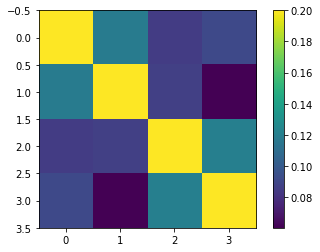

In [32]:
plt.imshow(mean_FC,vmax=0.2)
plt.colorbar()

# Slices - seeds 

In [108]:
option = 10
method = "slices"   # "average" (average signals -- 1st vestion), "slices" (corr per slice -- 2nd version)
auto = False    # If auto is True: template ROIs are used, 
               # if False: manual seeds
    
if auto:
    add = "ROIs"
else:
    add = "seeds"
    
tempfilt = "BP13"

input_den_image = get_filename(option, tempfilt)
out_name = get_option_foldername(option)
outfolderpath = f"PreProc-Comparison/{out_name}"

print(f"Input file: {input_den_image}")
print(f"Output folder: {out_name}")
print(f"Path: {outfolderpath}")

FC = sFCsorConnectivity(data_path, 
                        tempfilt=tempfilt,
                        out_folder=outfolderpath,
                        method=method,
                        auto=auto,
                        subIDs_to_exclude=["LU_AM","LU_LP","LU_RL","LU_VS"])

Input file: mfmri_st_corr_denoised_csf_pnm_moco_BP13
Output folder: 10_csf_pnm_moco_stc
Path: PreProc-Comparison/10_csf_pnm_moco_stc


In [109]:
run_FC = False

In [110]:
if run_FC:
    mean_FC = FC.run_allsubs_parallel(fname=input_den_image)
else:
    mean_FC = np.load(os.path.join(data_path,outfolderpath,tempfilt, method, add, f'FC_ave_all_{add}_{method}.npy'))

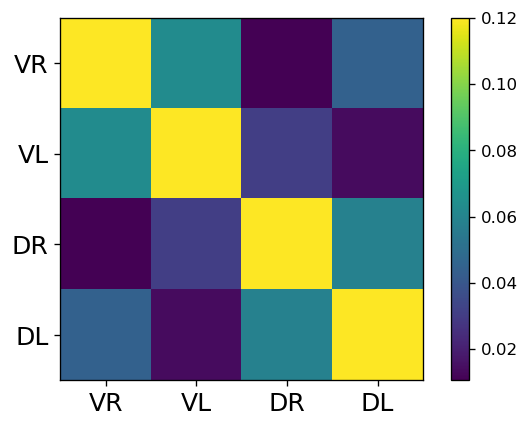

In [111]:
plt.figure(dpi=120)
plt.imshow(mean_FC,vmax=0.12)
plt.colorbar()
plt.xticks([0,1,2,3],["VR","VL","DR","DL"] , fontsize=15)
plt.yticks([0,1,2,3],["VR","VL","DR","DL"], fontsize=15)
plt.savefig("Fig1_FC.pdf")

In [112]:
mean_FC

array([[1.        , 0.06316592, 0.01060505, 0.0443863 ],
       [0.06316592, 1.        , 0.03075334, 0.01399935],
       [0.01060505, 0.03075334, 1.        , 0.05849299],
       [0.0443863 , 0.01399935, 0.05849299, 1.        ]])

## Computing median

In [101]:
corrs_all = np.zeros((len(FC.subjects_paths),4,4))
for i_s in tqdm(range(len(FC.subjects_paths))):
    sub_path = FC.subjects_paths[i_s]
    sub = sub_path.split('/')[-1]
    corrs_all[i_s,:,:] = np.load(os.path.join(FC.data_path, FC.out_folder,sub, 'FC_mat.npy'))


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 193.55it/s]


In [104]:
median_FC = np.median(corrs_all,axis=0)

'PreProc-Comparison/10_csf_pnm_moco_stc/BP13/slices/seeds'

In [105]:
median_FC

array([[1.        , 0.04923593, 0.00142582, 0.03823245],
       [0.04923593, 1.        , 0.02661347, 0.0202212 ],
       [0.00142582, 0.02661347, 1.        , 0.05725748],
       [0.03823245, 0.0202212 , 0.05725748, 1.        ]])

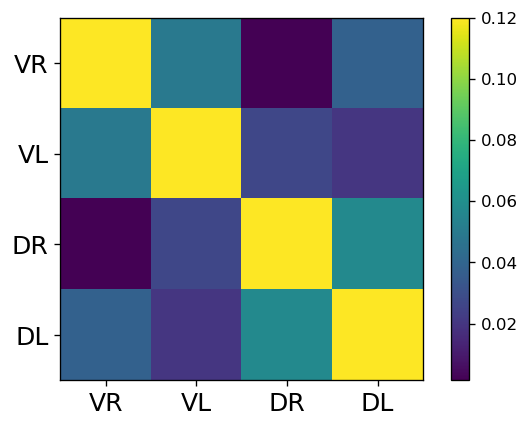

In [107]:
plt.figure(dpi=120)
plt.imshow(median_FC,vmax=0.12)
plt.colorbar()
plt.xticks([0,1,2,3],["VR","VL","DR","DL"] , fontsize=15)
plt.yticks([0,1,2,3],["VR","VL","DR","DL"], fontsize=15)
plt.savefig("Fig1_FC_median.pdf")

## Given the selected method -> per slice stats

In [24]:
option = 10
method = "slices"   # "average" (average signals -- 1st vestion), "slices" (corr per slice -- 2nd version)
auto = False    # If auto is True: template ROIs are used, 
               # if False: manual seeds
    
if auto:
    add = "ROIs"
else:
    add = "seeds"
    
tempfilt = "BP13"

input_den_image = get_filename(option, tempfilt)
out_name = get_option_foldername(option)
outfolderpath = f"PreProc-Comparison/{out_name}"

print(f"Input file: {input_den_image}")
print(f"Output folder: {out_name}")
print(f"Path: {outfolderpath}")

FC = sFCsorConnectivity(data_path, 
                        tempfilt=tempfilt,
                        out_folder=outfolderpath,
                        method=method,
                        auto=auto,
                        subIDs_to_exclude=["LU_AM","LU_LP","LU_RL","LU_VS"])

Input file: mfmri_st_corr_denoised_csf_pnm_moco_BP13
Output folder: 10_csf_pnm_moco_stc
Path: PreProc-Comparison/10_csf_pnm_moco_stc


In [29]:
perslice = False
if perslice:
    FC.corr_seed2vox_perslice('DR', fname=input_den_image)

# Denoising - in terms of noise reduction

Following Kaptan et al. 2022 and Birn at al. 2014, let's compute the $R^2$ as:

$R^2 = 1 - \frac{\sigma_{denoised}}{\sigma_{baseline}}$

and afterwards we compute its adjusted version 

$R^2_{adj} = 1 - [\frac{(1 - R^2)(n-1)}{(n-k-1)}]$, 

where n is the number of datapoints and k is the number of independent variables.



### Functions definition

In [38]:
def __load_seeds(seeds_array,seed):
    seeds_xyz = 0
    if seed == 'VR':
        seeds_xyz = np.array(np.where(seeds_array==1)).T    
    elif seed == 'VL':
        seeds_xyz = np.array(np.where(seeds_array==2)).T
    elif seed == 'DR':
        seeds_xyz = np.array(np.where(seeds_array==3)).T    
    elif seed == 'DL':
        seeds_xyz = np.array(np.where(seeds_array==4)).T

    return seeds_xyz

def __ts_to_average(f_img_data, seeds_xyz):
    # from time serieses to mean
    X = np.zeros((seeds_xyz.shape[0], f_img_data.shape[-1]))
    for i, xyz in enumerate(seeds_xyz):
        X[i,:] = f_img_data[xyz[0], xyz[1], xyz[2], :]

    return np.mean(X,0)

In [39]:
def compute_r2_persub(sub_path,input_fname, typefilter):
    
    # temporal filter to apply to the baseline
    low_cutoff = None
    high_cutoff = None
    if typefilter == "HP":
        low_cutoff = 1/100
    elif typefilter == "BP13":
        low_cutoff = 0.01
        high_cutoff = 0.13
    elif typefilter == "BP17":
        low_cutoff = 0.01
        high_cutoff = 0.17
    
    # load data subject baseline
    sub_path_func = os.path.join(sub_path,  'func', 'mfmri_st_corr.nii.gz') # not denoised fmri to perform filtering on
    if not os.path.exists(os.path.join(sub_path,  'func', f'mfmri_st_corr_tf_{typefilter}.nii.gz')):
        img_cleaned = clean_img(sub_path_func, low_pass=high_cutoff, high_pass=low_cutoff, t_r=2.5, standardize=False)
        nib.save(img_cleaned, os.path.join(sub_path,  'func', f'mfmri_st_corr_tf_{typefilter}.nii.gz'))
            
    baseline_path_func = os.path.join(sub_path,  'func', f'mfmri_st_corr_tf_{typefilter}.nii.gz')

    seed_mask = os.path.join(sub_path, 'func', 'mfmri_mean_seeds.nii.gz')
    
    sub_fmri_path = os.path.join(sub_path, 'func', input_fname+f'_{typefilter}.nii.gz')
    img = nib.load(sub_fmri_path)
    f_img_data = img.get_fdata()
    seeds = nib.load(seed_mask)
    seeds_array = seeds.get_fdata()  
    baseline_data = nib.load(baseline_path_func).get_fdata()
    
    # Load seeds
    vr_xyz = __load_seeds(seeds_array, 'VR')
    vl_xyz = __load_seeds(seeds_array, 'VL')
    dr_xyz = __load_seeds(seeds_array, 'DR')
    dl_xyz = __load_seeds(seeds_array, 'DL')
    
    # take time courses and compute RSS per slice
    zslices = np.unique(vr_xyz[:,2])
    Rsquared = np.zeros(len(zslices))
    for i,z in enumerate(zslices): # per slice 
        
        vrxyz = vr_xyz[np.where(vr_xyz[:,2]==z)[0]]
        VR_sig = __ts_to_average(f_img_data, vrxyz)
        vlxyz = vl_xyz[np.where(vl_xyz[:,2]==z)[0]]
        VL_sig = __ts_to_average(f_img_data, vlxyz)
        
        drxyz = dr_xyz[np.where(dr_xyz[:,2]==z)[0]]
        DR_sig = __ts_to_average(f_img_data, drxyz)
        dlxyz = dl_xyz[np.where(dl_xyz[:,2]==z)[0]]
        DL_sig = __ts_to_average(f_img_data, dlxyz)
        
        baseline_vr = __ts_to_average(baseline_data, vrxyz)
        baseline_vl = __ts_to_average(baseline_data, vlxyz)
        baseline_dr = __ts_to_average(baseline_data, drxyz)
        baseline_dl = __ts_to_average(baseline_data, dlxyz)
        
        R2_vr = 1 - (np.var(VR_sig)/np.var(baseline_vr))
        R2_vl = 1 - (np.var(VL_sig)/np.var(baseline_vl))
        R2_dr = 1 - (np.var(DR_sig)/np.var(baseline_dr))
        R2_dl = 1 - (np.var(DL_sig)/np.var(baseline_dl))
        
        # compute R squared per slice average
        Rsquared[i] = (R2_vr+R2_vl+R2_dr+R2_dl)/4
        

    return np.mean(Rsquared), Rsquared
    
    

In [40]:
subjects_paths = glob(os.path.join(data_path,"LU_*"))
#subj_to_exclude = ["LU_NK", "LU_VS", "LU_IR","LU_RL","LU_NS"]
subj_to_exclude = ["LU_AM","LU_LP","LU_RL","LU_VS"]
subjects_paths = [sub for sub in subjects_paths if sub.split('/')[-1] not in subj_to_exclude]
subjects_paths = sorted(subjects_paths)

## Analysis:

#### (Re)select filter

In [84]:
def IQR(dist):
    return np.percentile(dist, 5), np.percentile(dist, 95)

In [41]:
tempfilt = "BP13"

options_for_r2 = options_to_consider[1:]
options_for_r2

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [42]:
run_analysis = False

In [335]:
outpath = os.path.join(data_path,"PreProc-Comparison")
if run_analysis:
    n = 360
    # Compute var for all denoising option
    options_sigma_subs = {}
    
    ## change here the options 
    for o in tqdm(options_for_r2):
        finput, k = get_mfmri_den_details(o)
        r2_subs = np.zeros(len(subjects_paths))
        for s in trange(len(subjects_paths)):
            subpath = subjects_paths[s]
            # r2
            R2,_ = compute_r2_persub(subpath,finput,tempfilt)
            # compute R squared adjusted
            r2_subs[s] = 1 - ((1-R2)*(n-1))/(n-k-1)

        options_sigma_subs[o] = r2_subs
        
    with open(os.path.join(outpath,f'options_sigmas_subs_{tempfilt}.pkl'), 'wb') as f:
        pickle.dump(options_sigma_subs, f)

In [336]:
# Load the R2 for both BP and HO
if run_analysis==False:
    # load the saved
    with open(os.path.join(outpath,f'options_sigmas_subs_BP13.pkl'), 'rb') as f:
        options_sigma_subs = pickle.load(f)

In [337]:
options_sigma_subs

{1: array([ 0.01588575,  0.02119551,  0.00605165,  0.00282636,  0.0032763 ,
         0.00505777,  0.00121636,  0.00811061,  0.00380036,  0.01259515,
         0.00809324,  0.00457941,  0.00625212,  0.00293618,  0.00856398,
         0.00686082,  0.00293858,  0.004858  ,  0.00333075,  0.00409881,
        -0.32835669,  0.00496926,  0.00634849,  0.00329101]),
 2: array([0.02291074, 0.03625298, 0.0378349 , 0.01504766, 0.04893603,
        0.0149257 , 0.01364808, 0.08632865, 0.01249465, 0.03076193,
        0.01731936, 0.01676957, 0.0162684 , 0.01625992, 0.01831831,
        0.01373106, 0.04513937, 0.05780493, 0.01967397, 0.00499708,
        0.01462205, 0.0094377 , 0.03179574, 0.01434495]),
 3: array([0.05920116, 0.08114746, 0.11129062, 0.03090271, 0.09034943,
        0.10780617, 0.03472355, 0.15247887, 0.05281623, 0.08270142,
        0.04226851, 0.04909672, 0.03357297, 0.01654299, 0.03603301,
        0.08005943, 0.07505149, 0.11192273, 0.01901653, 0.01744253,
        0.06054921, 0.03260706, 0.0

In [339]:
np.median(options_sigma_subs[7])

0.1128362038009098

In [359]:
IQR(options_sigma_subs[11])

(0.11527248604075328, 0.22219377752945157)

In [147]:
### Generate dataframe

options_name = []
for o in options_sigma_subs.keys():
    options_name.append(get_option_foldername(o))

df = pd.DataFrame(columns=options_name)
# dfHP = pd.DataFrame(columns=options_name)

for i,o in enumerate(options_sigma_subs.keys()):
    df[options_name[i]] = options_sigma_subs[o]
    #dfHP[options_name[i]] = options_sigma_subs_HP[o]

    
# df.to_csv(f"Outputs_paper_data/{tempfilt}_RSS.csv")


In [148]:
write = run_analysis
if write:
    df.to_csv('Outputs_paper_data/BP13_RSS_st.csv')
else:
    df = pd.read_csv('Outputs_paper_data/BP13_RSS_st.csv',header=0,index_col=0,delimiter=",")


In [149]:
df

,1_csf_csfonly_stc,2_moco_stc,3_cc_stc,4_moco_cc_stc,5_pnm_cardonly_stc,6_pnm_responly_stc,7_pnm_stc,8_csf_pnm_stc,9_pnm_moco_stc,10_csf_pnm_moco_stc,11_csf_pnm_moco_cc_stc
0,0.015886,0.022911,0.059201,0.073255,0.018746,0.065175,0.125242,0.129164,0.134689,0.138687,0.155884
1,0.021196,0.036253,0.081147,0.092283,0.022030,0.061150,0.119510,0.135426,0.141590,0.151551,0.180927
2,0.006052,0.037835,0.111291,0.120950,0.024509,0.114119,0.181016,0.186313,0.188229,0.192880,0.213096
3,0.002826,0.015048,0.030903,0.039520,0.021855,0.042704,0.102734,0.105937,0.111580,0.114737,0.132846
4,0.003276,0.048936,0.090349,0.108930,0.023501,0.093098,0.153473,0.155833,0.169907,0.171970,0.192611
5,0.005058,0.014926,0.107806,0.115561,0.024567,0.126274,0.187941,0.193022,0.194773,0.199785,0.223139
6,0.001216,0.013648,0.034724,0.043605,0.019390,0.036374,0.091322,0.092775,0.098832,0.099943,0.120843
7,0.008111,0.086329,0.152479,0.176274,0.026252,0.132052,0.187356,0.194346,0.207343,0.212620,0.256887
8,0.003800,0.012495,0.052816,0.065575,0.024723,0.056601,0.113949,0.116882,0.123824,0.126412,0.149708
9,0.012595,0.030762,0.082701,0.092688,0.019881,0.051716,0.106229,0.119319,0.134133,0.141588,0.184640


### Stats

In [150]:
(np.mean(df.values,0))

array([-0.00755084,  0.02565099,  0.05917085,  0.07258259,  0.02375938,
        0.06216156,  0.12187188,  0.12691152,  0.13389649,  0.13830879,
        0.16113468])

In [151]:
(np.max(df.values,0))

array([0.02119551, 0.08632865, 0.15247887, 0.17627381, 0.03752006,
       0.13205223, 0.18794134, 0.19434618, 0.20734344, 0.21261957,
       0.2568873 ])

In [152]:
(np.min(df.values,0))

array([-0.32835669,  0.00499708,  0.01654299,  0.02201125,  0.01516777,
        0.02260693,  0.08069721,  0.08442969,  0.08543918,  0.08937262,
        0.10733903])

In [153]:
(np.median(df.values,0))

array([0.00491363, 0.01704446, 0.05095647, 0.06511879, 0.02282865,
       0.05415848, 0.1128362 , 0.11810069, 0.12742749, 0.13239715,
       0.15273424])

### Figure 

In [154]:
labels = []
errors = np.zeros(len(options_sigma_subs))
median_rsquared = np.zeros(len(options_sigma_subs))
i = 0
for o, rs in options_sigma_subs.items():
    name,_=get_mfmri_den_details(o)
    labels.append('_'.join(name.split('_')[4:]))
    median_rsquared[i] = np.median(rs)
    errors[i] = iqr(rs)
    i += 1
    

In [155]:
labels

['csf_csfonly',
 'moco',
 'cc',
 'moco_cc',
 'pnm_cardonly',
 'pnm_responly',
 'pnm',
 'csf_pnm',
 'pnm_moco',
 'csf_pnm_moco',
 'csf_pnm_moco_cc']

In [156]:
fig = go.Figure()
fig.add_trace(go.Bar(
    name='Denoising',
    x=labels, y=median_rsquared,
    error_y=dict(type='data', array=errors)
))

fig.update_layout(
    title="Plot Title",
    xaxis_title="Denoising options",
    yaxis_title="R squared")

# fig.add_trace(go.Bar(
#     name='Experimental',
#     x=['Trial 1', 'Trial 2', 'Trial 3'], y=[4, 7, 3],
#     error_y=dict(type='data', array=[0.5, 1, 2])
# ))
# fig.update_layout(barmode='group')
fig.show()
fig.write_html(f"Outputs_paper_figures/{tempfilt}_rsquared.html")

In [157]:
fig.write_image(f"Outputs_paper_figures/{tempfilt}_rsquared.png")

In [158]:
y_data = list(options_sigma_subs.values())
x_data = labels
colors = []
for i in range(len(options_sigma_subs)):
    colors.append(f'rgba({randrange(255)}, {randrange(255)}, {randrange(255)}, 0.5)')

fig = go.Figure()

for xd, yd, cls in zip(x_data, y_data, colors):
        fig.add_trace(go.Box(
            y=yd,
            name=xd,
            boxpoints='all',
            #jitter=0.5,
            whiskerwidth=0.2,
            fillcolor=cls,
            marker_size=4,
            line_width=1)
        )

fig.update_layout(
    title='Variance explained',
    yaxis=dict(
#         autorange=True,
         showgrid=True,
        zeroline=True,
#        dtick=5,
        tickcolor='black',
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
        title= "R2"
    ),
    margin=dict(
        l=40,
        r=30,
        b=80,
        t=100,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False
)

fig.show()
#fig.write_html(f"Outputs_paper_figures/{tempfilt}_distrsub_rsquared.html")

In [159]:
fig.write_image(f"Outputs_paper_figures/{tempfilt}_distrsub_rsquared.png")

In [160]:
denoising_names_r2=[]
for o in options_for_r2:
    denoising_names_r2.append(get_option_foldername(o))

In [350]:
rss_bp = pd.read_csv('Outputs_paper_data/BP13_RSS_st.csv',header=0,index_col=0,delimiter=",")

for i,val in enumerate(rss_bp.median()):
    print(f"{denoising_names_r2[i]} : {val} +- IQR : {errors[i]}")


1_csf_csfonly_stc : 0.00491362926865095 +- IQR : 0.9851919767694657
2_moco_stc : 0.01704446410126085 +- IQR : 1.0814216870250135
3_cc_stc : 0.05095647497507215 +- IQR : 1.0992394608078584
4_moco_cc_stc : 0.06511878697616286 +- IQR : 1.3466230939416306
5_pnm_cardonly_stc : 0.022828650096471698 +- IQR : 1.3328004575827546
6_pnm_responly_stc : 0.05415848114580635 +- IQR : 1.1898225004022773
7_pnm_stc : 0.11283620380090975 +- IQR : 1.086029342641952
8_csf_pnm_stc : 0.11810069048469016 +- IQR : 1.2237999783664133
9_pnm_moco_stc : 0.1274274942457695 +- IQR : 1.2869572304602954
10_csf_pnm_moco_stc : 0.13239714772980188 +- IQR : 1.2385992142140054
11_csf_pnm_moco_cc_stc : 0.15273423868335173 +- IQR : 1.311803139608271


In [374]:
IQR(rss_bp['6_pnm_responly_stc'].values)

(0.026342091327204685, 0.12445097154573245)

In [334]:
rss_bp

,1_csfonly,2_moco,3_cc,4_moco_cc,5_pnm_cardonly,6_pnm_responly,7_pnm,8_pnm_csf,9_pnm_moco,10_pnm_csf_moco,11_pnm_csf_moco_cc
0,0.155117,0.080664,0.153701,0.182484,-0.010094,0.225123,0.234380,0.233301,0.241357,0.240546,0.290526
1,0.041726,0.026561,0.146009,0.146182,0.016278,0.132034,0.257074,0.266661,0.292809,0.302025,0.307976
2,0.251798,0.309115,0.376980,0.385032,0.035625,0.234123,0.350695,0.508967,0.474203,0.539545,0.537382
3,0.022254,0.009947,0.007581,0.018879,0.037967,0.046837,0.105924,0.142345,0.153250,0.180586,0.189994
4,-0.001260,0.015851,0.034389,0.030859,0.011426,0.064741,0.135015,0.135213,0.156649,0.156805,0.157391
5,0.461090,0.304071,0.396115,0.394686,-0.000684,0.356541,0.322329,0.520579,0.374287,0.520679,0.537481
6,0.142972,0.034832,0.195885,0.227402,0.025445,0.146338,0.190145,0.246556,0.208858,0.260806,0.307931
7,0.066119,0.021422,0.221335,0.227445,0.026160,0.104440,0.188987,0.286380,0.199733,0.286193,0.352998
8,-0.002804,0.042698,0.013249,0.054420,-0.002983,0.049277,0.039136,0.037538,0.055521,0.057546,0.062879
9,0.002529,-0.001333,0.014865,0.009388,0.026750,0.105551,0.127812,0.129713,0.137734,0.143129,0.154903


### Stat differences

In [437]:
res_rss = {}
for i in range(1,11):
    tup = (i,i+1)
    res_rss[tup] = ttest_ind(options_sigma_subs[tup[0]],options_sigma_subs[tup[1]])

In [440]:
p_vals = []
for i, vals in res_rss.items():
    p_vals.append(vals[1])

multipletests(p_vals)

(array([False,  True, False,  True,  True,  True, False, False, False,
        False]),
 array([1.49122460e-01, 1.66876760e-03, 6.28850137e-01, 1.05499436e-06,
        6.72771633e-06, 1.05171323e-06, 8.59092454e-01, 8.59092454e-01,
        8.59092454e-01, 1.78839737e-01]),
 0.005116196891823743,
 0.005)

In [441]:
for i,v in res_rss.items():
    print(i,v)

(1, 2) Ttest_indResult(statistic=-2.2916115670284674, pvalue=0.026555542505404192)
(2, 3) Ttest_indResult(statistic=-3.985351115123411, pvalue=0.0002385660449560472)
(3, 4) Ttest_indResult(statistic=-1.2448984552822882, pvalue=0.21947408677728897)
(4, 5) Ttest_indResult(statistic=6.2616762361802305, pvalue=1.1722165088405004e-07)
(5, 6) Ttest_indResult(statistic=-5.6903726989441195, pvalue=8.409670168427742e-07)
(6, 7) Ttest_indResult(statistic=-6.2930287593110945, pvalue=1.051713730073762e-07)
(7, 8) Ttest_indResult(statistic=-0.5253190337223912, pvalue=0.6018845335702534)
(8, 9) Ttest_indResult(statistic=-0.71270035454789, pvalue=0.4796309984799163)
(9, 10) Ttest_indResult(statistic=-0.44097489803137013, pvalue=0.6612968518889443)
(10, 11) Ttest_indResult(statistic=-2.128987219884887, pvalue=0.038641025148038986)


## TSNR

In [166]:
def compute_tsnr_denoised_sub(subjectpath, inputname_denoised, outpath, inputname_mean="mfmri_st_corr_mean.nii.gz"):

    sub = subjectpath.split('/')[-1]
    # sum denoised to mean image
    outputsum = os.path.join(outpath, sub, 'mfmri_mean_den_sum.nii.gz')
    
    # TSNR at the fmri raw level
    
    path = os.path.join(subjectpath, 'func')
    adding_mean = ""
    if inputname_denoised != "mfmri_st_corr":
        # if it's not baseline add the mean
        adding_mean = f"fslmaths {inputname_denoised} -add {inputname_mean} {outputsum};"
    else:
        # if it's baseline, you compute it on the original
        outputsum = inputname_denoised+".nii.gz"
    
    runstring = f'cd {path}; {adding_mean} sct_fmri_compute_tsnr -i {outputsum} -v 0'
    print(runstring)
    os.system(runstring)    
    
    
def compute_ave_tsnr_persub(sub_path,path_preproc):

    sub = sub_path.split('/')[-1] 
    img_path = os.path.join(path_preproc, sub, 'mfmri_mean_den_sum_tsnr.nii.gz')
    if path_preproc.split("/")[-4] == "0_baseline_stc":
        img_path = os.path.join(sub_path, 'func/mfmri_st_corr_tsnr.nii.gz')
    
    # load data subject
    seed_mask = os.path.join(sub_path, 'func', 'mfmri_mean_seeds.nii.gz')
    
    img = nib.load(img_path)
    tsnr_fimg = img.get_fdata()
    seeds = nib.load(seed_mask)
    seeds_array = seeds.get_fdata()     
    
    # Load seeds
    vr_xyz = __load_seeds(seeds_array, 'VR')
    vl_xyz = __load_seeds(seeds_array, 'VL')
    dr_xyz = __load_seeds(seeds_array, 'DR')
    dl_xyz = __load_seeds(seeds_array, 'DL')
    
    
    xyz = np.vstack([vr_xyz,vl_xyz,dr_xyz,dl_xyz])
    tsnr = 0
    for x,y,z in xyz:
        tsnr += tsnr_fimg[x,y,z]
    
    # tsnr*=mult_fact_sub[sub]
    # average tsnr
    tsnr /= len(xyz)
    
    return tsnr
    
    

In [167]:
def compute_tsnr_perROI(sub_path, path_preproc):

    sub = sub_path.split('/')[-1] 
    img_path = os.path.join(path_preproc, sub, 'mfmri_mean_den_sum_tsnr.nii.gz')
    if path_preproc.split("/")[-4] == "0_baseline_stc":
        img_path = os.path.join(sub_path, 'func/mfmri_st_corr_tsnr.nii.gz')
    
    # load data subject
    seed_mask = os.path.join(sub_path, 'func', 'mfmri_mean_seeds.nii.gz')
    
    img = nib.load(img_path)
    tsnr_fimg = img.get_fdata()
    seeds = nib.load(seed_mask)
    seeds_array = seeds.get_fdata()     
    
    # Load seeds
    vr_xyz = __load_seeds(seeds_array, 'VR')
    vl_xyz = __load_seeds(seeds_array, 'VL')
    dr_xyz = __load_seeds(seeds_array, 'DR')
    dl_xyz = __load_seeds(seeds_array, 'DL')
    
    # xyz = np.vstack([vr_xyz,vl_xyz,dr_xyz,dl_xyz])
    tsnr_vr = 0
    for x,y,z in vr_xyz:
        tsnr_vr += tsnr_fimg[x,y,z]
    tsnr_vr /= len(vr_xyz)
    
    tsnr_vl = 0
    for x,y,z in vl_xyz:
        tsnr_vl += tsnr_fimg[x,y,z]
    tsnr_vl /= len(vl_xyz)    
    
    tsnr_dr = 0
    for x,y,z in dr_xyz:
        tsnr_dr += tsnr_fimg[x,y,z]
    tsnr_dr /= len(dr_xyz)
    
    tsnr_dl = 0
    for x,y,z in dl_xyz:
        tsnr_dl += tsnr_fimg[x,y,z]
    tsnr_dl /= len(dl_xyz)
    
    return tsnr_vr, tsnr_vl, tsnr_dr, tsnr_dl

In [259]:
# iterate over the pull of denoising options

method = "slices"
add = "seeds"
tsnr_options = {}
for option in tqdm(options_to_consider):
    input_den_image,_ = get_mfmri_den_details(option) 
    preproc='_'.join(input_den_image.split('_')[4:]) + "_stc"
    # add temp filter addition
    input_den_image += '_'+tempfilt
    if option == 0:
        preproc = "baseline_stc"
        input_den_image,_ = get_mfmri_den_details(option) 
            
    out_name = f"{option}_{preproc}"
    out_path = os.path.join(data_path,f"PreProc-Comparison/{out_name}",tempfilt,method,add)
    tsnr_sub = np.zeros(len(subjects_paths))
    # iterate over the subjects
    for i, sub in enumerate(subjects_paths):
        tsnr_sub[i] = compute_ave_tsnr_persub(sub,out_path)
    tsnr_options[option] = tsnr_sub


100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.87it/s]


In [260]:
tsnr_options

{0: array([10.16653461, 10.24101081,  7.39314749, 11.14724766, 10.20380901,
         8.81099762,  9.17873189,  9.26581396,  7.56719442,  8.91172941,
         6.67863599,  8.35433361,  8.9418712 ,  7.97941601,  8.11216135,
         9.5293921 ,  8.30504427,  6.03427326,  8.61443066,  8.98772662,
         7.83347441,  7.40085979,  8.114924  ,  8.71598453]),
 1: array([12.23106392, 12.72967633,  8.97312572, 13.3387191 , 12.44991042,
        10.53244284, 11.18168115, 11.09612046,  9.19427582, 11.40798304,
         8.17549342,  8.55631075, 10.67079963,  9.72945486, 10.02711329,
        11.70360837, 10.07174718,  7.27444509, 10.65373362, 10.92670303,
         9.92055075,  9.74563696, 10.7054177 , 10.7151406 ]),
 2: array([12.46917253, 12.80365978,  9.04228605, 13.67024498, 12.96874908,
        10.59412602, 11.26188998, 11.18666795,  9.39714941, 11.73060808,
         8.19096291,  9.91338667, 10.82767337,  9.79667955, 10.13964235,
        11.79071431, 10.1363741 ,  7.29776253, 10.7597408 , 10.9

In [313]:
tsnr_options_VR = {}
tsnr_options_VL = {}
tsnr_options_DR = {}
tsnr_options_DL = {}

for option in tqdm(options_to_consider):
    input_den_image,_ = get_mfmri_den_details(option) 
    preproc='_'.join(input_den_image.split('_')[4:])+"_stc"
    # add temp filter addition
    input_den_image += '_'+tempfilt
    if option == 0:
        preproc = "baseline_stc"
        input_den_image,_ = get_mfmri_den_details(option) 

    out_name = f"{option}_{preproc}"
    out_path = os.path.join(data_path,f"PreProc-Comparison/{out_name}",tempfilt,method,add)
    tsnr_sub_vr = np.zeros(len(subjects_paths))
    tsnr_sub_vl = np.zeros(len(subjects_paths))
    tsnr_sub_dr = np.zeros(len(subjects_paths))
    tsnr_sub_dl = np.zeros(len(subjects_paths))
    # iterate over the subjects
    for i, sub in enumerate(subjects_paths):
        tsnr_sub_vr[i],tsnr_sub_vl[i], tsnr_sub_dr[i], tsnr_sub_dl[i] = compute_tsnr_perROI(sub,out_path)
    
    tsnr_options_VR[option] = tsnr_sub_vr
    tsnr_options_VL[option] = tsnr_sub_vl
    tsnr_options_DR[option] = tsnr_sub_dr
    tsnr_options_DL[option] = tsnr_sub_dl

100%|███████████████████████████████████████████| 12/12 [00:06<00:00,  1.96it/s]


In [317]:
res_tsnr = {}
for i in range(11):
    tup = (0,i+1)
    res_tsnr[tup] = ttest_ind(tsnr_options[tup[0]],tsnr_options[tup[1]])
    print(tup, np.abs(np.median(tsnr_options[tup[0]])-np.median(tsnr_options[tup[1]])))

(0, 1) 1.9970590289020933
(0, 2) 2.1057522100803645
(0, 3) 2.1668479167150707
(0, 4) 2.317834579647876
(0, 5) 2.175646663926349
(0, 6) 2.3124725046482943
(0, 7) 3.083062253583165
(0, 8) 3.1340776772210077
(0, 9) 3.2188391768055027
(0, 10) 3.2696195040946385
(0, 11) 3.468074958561818


In [361]:
np.median(tsnr_options[11])

12.133282553065907

In [362]:
IQR(tsnr_options[11])

(9.298697939822167, 15.311398325159269)

In [331]:
(np.mean(tsnr_options[11])-np.mean(tsnr_options[0]))/np.mean(tsnr_options[0])

0.4200609401400983

In [263]:
p_vals = []
for i, vals in res_tsnr.items():
    p_vals.append(vals[1])

multipletests(p_vals)

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True]),
 array([1.02081672e-05, 4.88668802e-06, 2.83259384e-06, 2.10279832e-06,
        2.83259384e-06, 2.10279832e-06, 1.46257415e-08, 1.20172164e-08,
        9.89170146e-09, 8.12278023e-09, 2.28424413e-09]),
 0.004652171732197341,
 0.004545454545454546)

In [174]:
for i, v in res_tsnr.items():
    print(i, v)

(0, 1) Ttest_indResult(statistic=-4.955395163755599, pvalue=1.0208167153305345e-05)
(0, 2) Ttest_indResult(statistic=-5.378542773085096, pvalue=2.4433469973729796e-06)
(0, 3) Ttest_indResult(statistic=-5.740410854402414, pvalue=7.081492123359175e-07)
(0, 4) Ttest_indResult(statistic=-5.944685890641871, pvalue=3.504666931265567e-07)
(0, 5) Ttest_indResult(statistic=-5.660991974173529, pvalue=9.302005449198991e-07)
(0, 6) Ttest_indResult(statistic=-5.900080005057296, pvalue=4.0873159627607964e-07)
(0, 7) Ttest_indResult(statistic=-7.427544626075362, pvalue=2.0893916725582196e-09)
(0, 8) Ttest_indResult(statistic=-7.523710794489529, pvalue=1.5021521018265638e-09)
(0, 9) Ttest_indResult(statistic=-7.61491587131019, pvalue=1.0990779096547802e-09)
(0, 10) Ttest_indResult(statistic=-7.70334111318227, pvalue=8.122780386176025e-10)
(0, 11) Ttest_indResult(statistic=-8.104311838605065, pvalue=2.0765850439324401e-10)


### Saving data

In [264]:
denoising_names = []
for o in options_to_consider:
    denoising_names.append(get_option_foldername(o))

In [265]:
def data_to_df(tsnr_data,colsnames):

    tsnr_df = pd.DataFrame(columns=colsnames)

    for i,o in enumerate(tsnr_options.keys()):
        tsnr_df[denoising_names[i]] = tsnr_data[o]
    
    return tsnr_df

In [266]:
tsnr_df = data_to_df(tsnr_options,denoising_names)

In [310]:
tsnr_df

,0_baseline_stc,1_csf_csfonly_stc,2_moco_stc,3_cc_stc,4_moco_cc_stc,5_pnm_cardonly_stc,6_pnm_responly_stc,7_pnm_stc,8_csf_pnm_stc,9_pnm_moco_stc,10_csf_pnm_moco_stc,11_csf_pnm_moco_cc_stc
0,10.166535,12.231064,12.469173,13.040330,13.155217,12.472672,13.105064,14.138938,14.207808,14.250736,14.314648,14.633964
1,10.241011,12.729676,12.803660,13.447682,13.543839,12.991269,13.646662,14.666678,14.736591,14.773259,14.843068,15.187218
2,7.393147,8.973126,9.042286,9.181220,9.252248,9.145588,9.227671,9.847960,9.872441,9.921238,9.944011,10.143195
3,11.147248,13.338719,13.670245,14.033588,14.220773,13.619196,14.121600,15.153097,15.196892,15.349065,15.392148,15.711961
4,10.203809,12.449910,12.968749,13.580309,13.836389,12.697346,13.431064,14.406642,14.490699,14.654561,14.725843,15.333312
5,8.810998,10.532443,10.594126,10.857208,10.961771,10.751542,10.926524,11.687497,11.726953,11.789191,11.826928,12.085672
6,9.178732,11.181681,11.261890,11.499754,11.628290,11.451248,11.475320,12.320737,12.368091,12.434554,12.483223,12.799138
7,9.265814,11.096120,11.186668,11.235430,11.354852,11.319913,11.342848,12.142141,12.183326,12.262143,12.301357,12.522980
8,7.567194,9.194276,9.397149,9.593206,9.700936,9.382010,9.641550,10.306510,10.344635,10.401438,10.437044,10.709752
9,8.911729,11.407983,11.730608,12.121806,12.292514,11.617153,12.095478,12.964697,13.026404,13.203098,13.262490,13.631072


In [268]:
# save
tsnr_df.to_csv(f"Outputs_paper_data/{tempfilt}_tsnr.csv")
#tsnr_hp.to_csv(f"Outputs_paper_data/HP_RSS.csv")

In [269]:
tsnr_options_VR_df = data_to_df(tsnr_options_VR,denoising_names)
tsnr_options_VL_df = data_to_df(tsnr_options_VL,denoising_names)
tsnr_options_DR_df = data_to_df(tsnr_options_DR,denoising_names)
tsnr_options_DL_df = data_to_df(tsnr_options_DL,denoising_names)

In [270]:
tsnr_options_VR_df.to_csv(f"Outputs_paper_data/{tempfilt}_tsnr_VR.csv")
tsnr_options_VL_df.to_csv(f"Outputs_paper_data/{tempfilt}_tsnr_VL.csv")
tsnr_options_DR_df.to_csv(f"Outputs_paper_data/{tempfilt}_tsnr_DR.csv")
tsnr_options_DL_df.to_csv(f"Outputs_paper_data/{tempfilt}_tsnr_DL.csv")

In [354]:
IQR(tsnr_options_VR_df["10_csf_pnm_moco_stc"].values)

(8.233883603269405, 15.41431128838483)

In [355]:
IQR(tsnr_options_VL_df["10_csf_pnm_moco_stc"].values)

(8.089075184301896, 15.741950387954711)

In [356]:
IQR(tsnr_options_DR_df["10_csf_pnm_moco_stc"].values)

(10.043980788028602, 14.363371597084342)

In [357]:
IQR(tsnr_options_DL_df["10_csf_pnm_moco_stc"].values)

(10.067132307688397, 15.151372215607585)

### Plots/data for tSNR

In [273]:
tsnr = pd.read_csv('Outputs_paper_data/BP13_tsnr.csv',header=0,index_col=0,delimiter=",")

In [274]:
tsnr

,0_baseline_stc,1_csf_csfonly_stc,2_moco_stc,3_cc_stc,4_moco_cc_stc,5_pnm_cardonly_stc,6_pnm_responly_stc,7_pnm_stc,8_csf_pnm_stc,9_pnm_moco_stc,10_csf_pnm_moco_stc,11_csf_pnm_moco_cc_stc
0,10.166535,12.231064,12.469173,13.040330,13.155217,12.472672,13.105064,14.138938,14.207808,14.250736,14.314648,14.633964
1,10.241011,12.729676,12.803660,13.447682,13.543839,12.991269,13.646662,14.666678,14.736591,14.773259,14.843068,15.187218
2,7.393147,8.973126,9.042286,9.181220,9.252248,9.145588,9.227671,9.847960,9.872441,9.921238,9.944011,10.143195
3,11.147248,13.338719,13.670245,14.033588,14.220773,13.619196,14.121600,15.153097,15.196892,15.349065,15.392148,15.711961
4,10.203809,12.449910,12.968749,13.580309,13.836389,12.697346,13.431064,14.406642,14.490699,14.654561,14.725843,15.333312
5,8.810998,10.532443,10.594126,10.857208,10.961771,10.751542,10.926524,11.687497,11.726953,11.789191,11.826928,12.085672
6,9.178732,11.181681,11.261890,11.499754,11.628290,11.451248,11.475320,12.320737,12.368091,12.434554,12.483223,12.799138
7,9.265814,11.096120,11.186668,11.235430,11.354852,11.319913,11.342848,12.142141,12.183326,12.262143,12.301357,12.522980
8,7.567194,9.194276,9.397149,9.593206,9.700936,9.382010,9.641550,10.306510,10.344635,10.401438,10.437044,10.709752
9,8.911729,11.407983,11.730608,12.121806,12.292514,11.617153,12.095478,12.964697,13.026404,13.203098,13.262490,13.631072


In [84]:
def IQR(dist):
    return np.percentile(dist, 5), np.percentile(dist, 95)

In [186]:
errors = np.zeros(len(tsnr_options))
median_tsnr = np.zeros(len(tsnr_options))
i = 0
labels = []
for o, t in tsnr_options.items():
    name,_=get_mfmri_den_details(o)
    if o == 0:
        labels.append("baseline")
    else:
        labels.append('_'.join(name.split('_')[2:]))
    median_tsnr[i] = np.median(t)
    errors[i] = iqr(t)
    i += 1
    

In [187]:
fig = go.Figure()
fig.add_trace(go.Bar(
    name='Denoising',
    x=labels, y=median_tsnr,
    error_y=dict(type='data', array=errors)
))

fig.update_layout(
    title="Plot Title",
    xaxis_title="Denoising options",
    yaxis_title="tSNR")

# fig.add_trace(go.Bar(
#     name='Experimental',
#     x=['Trial 1', 'Trial 2', 'Trial 3'], y=[4, 7, 3],
#     error_y=dict(type='data', array=[0.5, 1, 2])
# ))
# fig.update_layout(barmode='group')
fig.show()
# fig.write_html(f"Outputs_paper_figures/{tempfilt}_tsnr.html")
# fig.write_image(f"Outputs_paper_figures/{tempfilt}_tsnr.png")

In [271]:
errors = np.zeros(len(tsnr_options))
median_tsnr = np.zeros(len(tsnr_options))
i = 0
labels = []
for o, t in tsnr_options_DL.items():
    name,_=get_mfmri_den_details(o)
    if o == 0:
        labels.append("baseline")
    else:
        labels.append('_'.join(name.split('_')[2:]))
    median_tsnr[i] = np.median(t)
    errors[i] = iqr(t)
    i += 1

In [272]:
for i,den in enumerate(denoising_names):
    print(f"{den} : {median_tsnr[i]} += iqr [{errors[i]}]")

0_baseline_stc : 8.860808592576248 += iqr [0.9851919767694657]
1_csf_csfonly_stc : 10.690810095362302 += iqr [1.0814216870250135]
2_moco_stc : 10.763876613079578 += iqr [1.0992394608078584]
3_cc_stc : 11.015756816346181 += iqr [1.3466230939416306]
4_moco_cc_stc : 11.104959535382992 += iqr [1.3328004575827546]
5_pnm_cardonly_stc : 10.838461779746687 += iqr [1.1898225004022773]
6_pnm_responly_stc : 10.99289361378442 += iqr [1.086029342641952]
7_pnm_stc : 11.776159433493937 += iqr [1.2237999783664133]
8_csf_pnm_stc : 11.869723235754142 += iqr [1.2869572304602954]
9_pnm_moco_stc : 11.947326053090457 += iqr [1.2385992142140054]
10_csf_pnm_moco_stc : 12.033892922040796 += iqr [1.311803139608271]
11_csf_pnm_moco_cc_stc : 12.288040563839825 += iqr [1.4372483178427675]


# Box-plot stats on the 4 connectivity

In [30]:
subjects_paths = FC.subjects_paths

In [31]:
tempfilt = 'BP13'

In [32]:
get_option_foldername(0)

'0_baseline_stc'

In [113]:
# method definition
method = "slices"   # "average" (average signals -- 1st vestion), "slices" (corr per slice -- 2nd version)
auto = False    # If auto is True: template ROIs are used, 
               # if False: manual seeds

if auto:
    add = "ROIs"
else:
    add = "seeds"

#  dictionary per option
tempfilt = "BP13"
options_fc_subs = {}
options_z_subs = {}

for o in tqdm(options_to_consider):
    

    input_den_image = get_filename(o, tempfilt)
    out_name = get_option_foldername(o)
    outfolderpath = f"PreProc-Comparison/{out_name}"


    # V-V 0,1
    # D-D 2,3
    # VR-DR 0,2  --> within
    # VL-DL 1,3  --> within 
    # VR-DL 0,3  --> between
    # VL-DR 1,2  --> between
    dist_corr_vv = []
    dist_corr_dd = []
    dist_corr_within = []
    dist_corr_between = []
    
    dist_corr_vv_z = []
    dist_corr_dd_z = []
    dist_corr_within_z = []
    dist_corr_between_z = []
    
    
    
    for s in trange(len(subjects_paths)):
        subname = subjects_paths[s].split('/')[-1]
        print(subname)
        # np.load(os.path.join(data_path,outfolderpath,tempfilt, method, add, f'FC_ave_all_{add}_{method}.npy'))
        file_to_read = os.path.join(data_path,outfolderpath,tempfilt,method,add,subname,f'FC_mat.npy')
        #print(f"Loading {file_to_read}")
        mat = np.load(file_to_read)
        mat_z_fisher = np.arctanh(mat-np.eye(4))
        
        dist_corr_vv.append(mat[0,1])
        dist_corr_dd.append(mat[2,3])
        dist_corr_within.append((mat[0,2]+mat[1,3])/2)
        #dist_corr_within.append(mat[1,3])
        dist_corr_between.append((mat[0,3]+mat[1,2])/2)
        #dist_corr_between.append(mat[1,2])
        
        dist_corr_vv_z.append(mat_z_fisher[0,1])
        dist_corr_dd_z.append(mat_z_fisher[2,3])
        dist_corr_within_z.append((mat_z_fisher[0,2]+mat_z_fisher[1,3])/2)
        #dist_corr_within_z.append(mat_z_fisher[1,3])
        dist_corr_between_z.append((mat_z_fisher[0,3]+mat_z_fisher[1,2])/2)
        #dist_corr_between_z.append(mat_z_fisher[1,2])
    
    
    options_fc_subs[o] = {'VV': dist_corr_vv, 'DD': dist_corr_dd, 'W':dist_corr_within, 'B':dist_corr_between}
    options_z_subs[o] = {'VV': dist_corr_vv_z, 'DD': dist_corr_dd_z, 'W':dist_corr_within_z, 'B':dist_corr_between_z}

  0%|                                                    | 0/12 [00:00<?, ?it/s]

LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP


  8%|███▋                                        | 1/12 [00:00<00:03,  3.42it/s]

LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC
LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG


 17%|███████▎                                    | 2/12 [00:00<00:02,  3.47it/s]

LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC
LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC
LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM


 33%|██████████████▋                             | 4/12 [00:00<00:01,  4.10it/s]

LU_NS
LU_NB
LU_AF
LU_MC
LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC


 42%|██████████████████▎                         | 5/12 [00:01<00:01,  3.78it/s]

LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL


 50%|██████████████████████                      | 6/12 [00:01<00:01,  4.38it/s]

LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC
LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC


 58%|█████████████████████████▋                  | 7/12 [00:01<00:01,  4.17it/s]

LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP


 67%|█████████████████████████████▎              | 8/12 [00:01<00:00,  5.04it/s]

LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC
LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC
LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR


 83%|███████████████████████████████████▊       | 10/12 [00:01<00:00,  5.60it/s]

LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC
LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC
LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  5.69it/s]

LU_NS
LU_NB
LU_AF
LU_MC
LU_AR
LU_MT



In [114]:
options_fc_subs[0]['VV']

[0.14987751906040525,
 0.28665350269459994,
 0.05771415572920308,
 0.15134219800903304,
 0.2542296695234079,
 0.13773905503557682,
 0.09245862154771235,
 0.10067446926559463,
 0.041772417564144945,
 0.2854300645608027,
 0.0784837076426359,
 0.11430990028757013,
 0.2256936379323244,
 0.2587069894796332,
 0.22346223202587198,
 0.10592438674829034,
 0.07423674054818974,
 0.055116850361280174,
 0.208684848552215,
 0.27419891943864816,
 0.10820017391257432,
 0.20572986883900007,
 0.17211326562927753,
 0.030214677436101806]

In [115]:
all_values = []
for k in options_fc_subs.keys():
    all_values.extend(options_fc_subs[k]['VV'])
    all_values.extend(options_fc_subs[k]['DD'])
    all_values.extend(options_fc_subs[k]['W'])
    all_values.extend(options_fc_subs[k]['B'])

In [116]:
kstest(all_values,"norm",N=24)

KstestResult(statistic=0.4781397290395744, pvalue=1.3399769563981403e-242)

In [117]:
all_values_VV = []
all_values_DD = []
all_values_W = []
all_values_B = []

for k in options_fc_subs.keys():
    all_values_VV.extend(options_fc_subs[k]['VV'])
    all_values_DD.extend(options_fc_subs[k]['DD'])
    all_values_W.extend(options_fc_subs[k]['W'])
    all_values_B.extend(options_fc_subs[k]['B'])

In [118]:
kstest(all_values_W,"norm",N=17)

KstestResult(statistic=0.4755355623729078, pvalue=2.4169678945652225e-60)

## Statistical test

In [119]:
for k in options_z_subs.keys():
    print(f"Option {get_option_foldername(k)}")
    print("VV:")
    print(kstest(options_fc_subs[k]["VV"],"norm",N=17))
    print("DD:")
    print(kstest(options_fc_subs[k]["DD"],"norm",N=17))
    print("W:")
    print(kstest(options_fc_subs[k]["W"],"norm",N=17))
    print("B:")
    print(kstest(options_fc_subs[k]["B"],"norm",N=17))


Option 0_baseline_stc
VV:
KstestResult(statistic=0.5120520785126143, pvalue=2.298327807390228e-06)
DD:
KstestResult(statistic=0.5028782058535232, pvalue=3.842497464688198e-06)
W:
KstestResult(statistic=0.4931860722282534, pvalue=6.527407752611242e-06)
B:
KstestResult(statistic=0.4975831440592395, pvalue=5.14108584592845e-06)
Option 1_csf_csfonly_stc
VV:
KstestResult(statistic=0.5000127272527007, pvalue=4.500429103239075e-06)
DD:
KstestResult(statistic=0.4984850822939241, pvalue=4.893727803603052e-06)
W:
KstestResult(statistic=0.4902712653957845, pvalue=7.635243502394628e-06)
B:
KstestResult(statistic=0.5022475615911773, pvalue=3.978908096822536e-06)
Option 2_moco_stc
VV:
KstestResult(statistic=0.5051085272281699, pvalue=3.3949605416857147e-06)
DD:
KstestResult(statistic=0.49880383797847444, pvalue=4.809052165481153e-06)
W:
KstestResult(statistic=0.4878799961586011, pvalue=8.675438469608438e-06)
B:
KstestResult(statistic=0.5023042478777103, pvalue=3.966460307677424e-06)
Option 3_cc_stc


In [120]:
denoising_names=[]
for o in options_to_consider:
    denoising_names.append(get_option_foldername(o))

In [121]:
denoising_names

['0_baseline_stc',
 '1_csf_csfonly_stc',
 '2_moco_stc',
 '3_cc_stc',
 '4_moco_cc_stc',
 '5_pnm_cardonly_stc',
 '6_pnm_responly_stc',
 '7_pnm_stc',
 '8_csf_pnm_stc',
 '9_pnm_moco_stc',
 '10_csf_pnm_moco_stc',
 '11_csf_pnm_moco_cc_stc']

In [122]:
vv_df = pd.DataFrame(columns=denoising_names)
dd_df = pd.DataFrame(columns=denoising_names)
w_df = pd.DataFrame(columns=denoising_names)
b_df = pd.DataFrame(columns=denoising_names)

for i in options_z_subs.keys():
    vv_df[get_option_foldername(i)] = options_z_subs[i]["VV"]
    dd_df[get_option_foldername(i)] = options_z_subs[i]["DD"]
    w_df[get_option_foldername(i)] = options_z_subs[i]["W"]
    b_df[get_option_foldername(i)] = options_z_subs[i]["B"]
    
    
vv_df["subID"] = np.arange(24)
dd_df["subID"] = np.arange(24)
w_df["subID"] = np.arange(24)
b_df["subID"] = np.arange(24)

# # long format adapt
vv_df_long = pd.melt(vv_df.reset_index(),id_vars="subID",value_vars=denoising_names)
dd_df_long = pd.melt(dd_df.reset_index(),id_vars="subID",value_vars=denoising_names)
w_df_long = pd.melt(w_df.reset_index(),id_vars="subID",value_vars=denoising_names)
b_df_long = pd.melt(b_df.reset_index(),id_vars="subID",value_vars=denoising_names)


In [123]:
vv_df_corr = pd.DataFrame(columns=denoising_names)
dd_df_corr = pd.DataFrame(columns=denoising_names)
w_df_corr = pd.DataFrame(columns=denoising_names)
b_df_corr = pd.DataFrame(columns=denoising_names)

for i in options_z_subs.keys():
    vv_df_corr[get_option_foldername(i)] = options_fc_subs[i]["VV"]
    dd_df_corr[get_option_foldername(i)] = options_fc_subs[i]["DD"]
    w_df_corr[get_option_foldername(i)] = options_fc_subs[i]["W"]
    b_df_corr[get_option_foldername(i)] = options_fc_subs[i]["B"]
    
    
vv_df_corr["subID"] = np.arange(24)
dd_df_corr["subID"] = np.arange(24)
w_df_corr["subID"] = np.arange(24)
b_df_corr["subID"] = np.arange(24)


In [124]:
vv_df_corr

,0_baseline_stc,1_csf_csfonly_stc,2_moco_stc,3_cc_stc,4_moco_cc_stc,5_pnm_cardonly_stc,6_pnm_responly_stc,7_pnm_stc,8_csf_pnm_stc,9_pnm_moco_stc,10_csf_pnm_moco_stc,11_csf_pnm_moco_cc_stc,subID
0,0.149878,0.166755,0.131392,0.039946,0.042933,0.157637,0.035849,0.024086,0.025743,0.022825,0.024593,0.012726,0
1,0.286654,0.184210,0.186364,0.132046,0.131884,0.184740,0.133539,0.123880,0.120183,0.125860,0.122168,0.107082,1
2,0.057714,0.039719,0.044538,0.041035,0.041049,0.046267,0.038606,0.041823,0.040498,0.045031,0.043813,0.044476,2
3,0.151342,0.154067,0.110415,0.063681,0.059466,0.141308,0.070812,0.048331,0.050867,0.042382,0.045307,0.037779,3
4,0.254230,0.238139,0.196218,0.101893,0.104700,0.238130,0.151595,0.154388,0.153612,0.152289,0.151009,0.094900,4
5,0.137739,0.086529,0.086732,0.022514,0.024475,0.086724,0.048239,0.037674,0.033666,0.043228,0.039166,0.020704,5
6,0.092459,0.032763,0.028433,0.010596,0.006772,0.020052,0.024966,0.014119,0.014075,0.012511,0.012774,-0.000881,6
7,0.100674,0.089960,0.080969,0.070613,0.065534,0.085540,0.077528,0.072335,0.070018,0.066917,0.064894,0.053048,7
8,0.041772,0.000032,0.012806,0.014787,0.020503,-0.009766,0.034361,0.017275,0.018129,0.020650,0.022689,0.017272,8
9,0.285430,0.166295,0.149817,0.056430,0.057958,0.166861,0.086660,0.078065,0.074737,0.079838,0.076493,0.038479,9


In [125]:
# dd_corrs = []
# w_corrs = []
# b_corrs = []

In [126]:
means_dn = np.zeros(len(denoising_names))
std_dn = np.zeros(len(denoising_names))
for i, dn in enumerate(denoising_names):
#     dd_corrs.extend(dd_df_corr[dn])
#     w_corrs.extend(w_df_corr[dn])
#     b_corrs.extend(b_df_corr[dn])
    
    means_dn[i] = np.median(vv_df_corr[dn])
    std_dn[i] = iqr(vv_df_corr[dn])

In [127]:
#wilcoxon(dd_corrs,b_corrs)

In [128]:
#wilcoxon(dd_corrs,w_corrs)

In [129]:
for o in options_to_consider:
    print(denoising_names[o], means_dn[o],std_dn[o])


0_baseline_stc 0.14380828704799103 0.13505519043104186
1_csf_csfonly_stc 0.0882446318615469 0.11232553275274591
2_moco_stc 0.08779534232357866 0.08458547022437032
3_cc_stc 0.05610892788340774 0.04613303729007039
4_moco_cc_stc 0.05608510337405678 0.04005117990086414
5_pnm_cardonly_stc 0.08936971052642168 0.10265714155585359
6_pnm_responly_stc 0.060757761059551926 0.04790817504497505
7_pnm_stc 0.05304763062743395 0.04296297126465689
8_csf_pnm_stc 0.05049871105480553 0.04182775751100651
9_pnm_moco_stc 0.05124370056212141 0.03508257050876951
10_csf_pnm_moco_stc 0.04923592733205681 0.030898284708118916
11_csf_pnm_moco_cc_stc 0.041807146250100374 0.0311063425778108


In [130]:
IQR(b_df_corr["11_csf_pnm_moco_cc_stc"])

(0.0007305997409940861, 0.05593932003012251)

In [131]:
np.mean(means_dn)

0.06900023999192273

In [132]:
np.mean(std_dn)

0.06254947114752366

In [133]:
dd_df

,0_baseline_stc,1_csf_csfonly_stc,2_moco_stc,3_cc_stc,4_moco_cc_stc,5_pnm_cardonly_stc,6_pnm_responly_stc,7_pnm_stc,8_csf_pnm_stc,9_pnm_moco_stc,10_csf_pnm_moco_stc,11_csf_pnm_moco_cc_stc,subID
0,0.094593,0.062057,0.047550,0.045065,0.037107,0.065220,0.033386,0.022889,0.019540,0.020488,0.017259,0.007821,0
1,0.262605,0.181467,0.185646,0.119129,0.119549,0.179454,0.103751,0.104140,0.097627,0.104674,0.097615,0.081565,1
2,0.009345,-0.001023,0.002365,-0.004488,0.002718,-0.005814,-0.003611,-0.000840,0.000039,0.004839,0.006065,0.017466,2
3,0.194947,0.114623,0.089386,0.058896,0.053665,0.110158,0.044258,0.041315,0.043283,0.036617,0.038240,0.032189,3
4,0.268671,0.210369,0.175489,0.079730,0.087547,0.213475,0.119382,0.115002,0.112249,0.116551,0.114989,0.069998,4
5,0.040891,0.009760,0.010190,-0.005271,-0.001300,0.012040,0.001480,-0.009163,-0.014512,-0.005458,-0.009816,-0.005807,5
6,0.047154,-0.003797,-0.002998,-0.015226,-0.013160,-0.002916,-0.006569,-0.011645,-0.012777,-0.008332,-0.009961,-0.016815,6
7,0.050422,0.075698,0.076047,0.074199,0.073967,0.072135,0.074464,0.079175,0.079367,0.081212,0.081243,0.083145,7
8,0.007215,0.000260,0.019393,0.009253,0.017256,-0.011654,0.033995,0.028981,0.029842,0.035796,0.036697,0.024782,8
9,0.355203,0.194091,0.153324,0.052920,0.056896,0.191174,0.113900,0.102511,0.097799,0.082196,0.074187,0.046042,9


In [134]:
### save dataframes
    
vv_df.to_csv(f"Outputs_paper_data/{tempfilt}_VV_FC_zfisher.csv")
dd_df.to_csv(f"Outputs_paper_data/{tempfilt}_DD_FC_zfisher.csv")
w_df.to_csv(f"Outputs_paper_data/{tempfilt}_W_FC_zfisher.csv")
b_df.to_csv(f"Outputs_paper_data/{tempfilt}_B_FC_zfisher.csv")

vv_df_corr.to_csv(f"Outputs_paper_data/{tempfilt}_VV_FC.csv")
dd_df_corr.to_csv(f"Outputs_paper_data/{tempfilt}_DD_FC.csv")
w_df_corr.to_csv(f"Outputs_paper_data/{tempfilt}_W_FC.csv")
b_df_corr.to_csv(f"Outputs_paper_data/{tempfilt}_B_FC.csv")

In [135]:
vv_df_long

,subID,variable,value
0,0,0_baseline_stc,0.151015
1,1,0_baseline_stc,0.294916
2,2,0_baseline_stc,0.057778
3,3,0_baseline_stc,0.152514
4,4,0_baseline_stc,0.259930
...,...,...,...
283,19,11_csf_pnm_moco_cc_stc,0.108936
284,20,11_csf_pnm_moco_cc_stc,0.054251
285,21,11_csf_pnm_moco_cc_stc,0.053654
286,22,11_csf_pnm_moco_cc_stc,0.043298


In [136]:
# method definition
method = "slices"   # "average" (average signals -- 1st vestion), "slices" (corr per slice -- 2nd version)
auto = False    # If auto is True: template ROIs are used, 
               # if False: manual seeds

if auto:
    add = "ROIs"
else:
    add = "seeds"

#  dictionary per option
tempfilt = "BP13"
options_fc_subs = {}
options_z_subs = {}

o = 10
    

input_den_image = get_filename(o, tempfilt)
out_name = get_option_foldername(o)
outfolderpath = f"PreProc-Comparison/{out_name}"


# V-V 0,1
# D-D 2,3
# VR-DR 0,2  --> within
# VL-DL 1,3  --> within 
# VR-DL 0,3  --> between
# VL-DR 1,2  --> between
dist_corr_vv = []
dist_corr_dd = []
dist_corr_within_VRDR = []
dist_corr_within_VLDL = []
dist_corr_between_VRDL = []
dist_corr_between_VLDR = []


for s in trange(len(subjects_paths)):
    subname = subjects_paths[s].split('/')[-1]
    print(subname)
    # np.load(os.path.join(data_path,outfolderpath,tempfilt, method, add, f'FC_ave_all_{add}_{method}.npy'))
    file_to_read = os.path.join(data_path,outfolderpath,tempfilt,method,add,subname,f'FC_mat.npy')
    #print(f"Loading {file_to_read}")
    mat = np.load(file_to_read)
    mat_z_fisher = np.arctanh(mat-np.eye(4))

    dist_corr_vv.append(mat[0,1])
    dist_corr_dd.append(mat[2,3])
    dist_corr_within_VRDR.append(mat[0,2])
    dist_corr_within_VLDL.append(mat[1,3])
    dist_corr_between_VRDL.append(mat[0,3])
    dist_corr_between_VLDR.append(mat[1,2])

LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC
LU_AR
LU_MT



In [92]:
r1 = wilcoxon(dist_corr_between_VRDL)
r2 = wilcoxon(dist_corr_between_VLDR)
r3 = wilcoxon(dist_corr_within_VLDL)
r4 = wilcoxon(dist_corr_within_VRDR)
r5 = wilcoxon(dist_corr_vv)
r6 = wilcoxon(dist_corr_dd)

In [146]:
pvals = [r5[1], r6[1],r1[1],r2[1],r3[1],r4[1]]

In [148]:
pvals

[1.1920928955078125e-07,
 1.1920928955078125e-06,
 1.1920928955078125e-07,
 1.049041748046875e-05,
 0.05264079570770264,
 0.4223414659500122]

In [149]:
multipletests(pvals,method='fdr_bh')

(array([ True,  True,  True,  True, False, False]),
 array([3.57627869e-07, 2.38418579e-06, 3.57627869e-07, 1.57356262e-05,
        6.31689548e-02, 4.22341466e-01]),
 0.008512444610847103,
 0.008333333333333333)

In [282]:
vv_res = {}
dd_res = {}
b_res = {}
w_res = {}

for o in denoising_names:
    vv_res[o] = wilcoxon(vv_df_corr[o].values)
    dd_res[o] = wilcoxon(dd_df_corr[o].values)    
    b_res[o] = wilcoxon(w_df_corr[o].values)
    w_res[o] = wilcoxon(b_df_corr[o].values)    

In [221]:
vv_res

{'0_baseline_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '1_csf_csfonly_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '2_moco_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '3_cc_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '4_moco_cc_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '5_pnm_cardonly_stc': WilcoxonResult(statistic=1.0, pvalue=2.384185791015625e-07),
 '6_pnm_responly_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '7_pnm_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '8_csf_pnm_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '9_pnm_moco_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '10_csf_pnm_moco_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '11_csf_pnm_moco_cc_stc': WilcoxonResult(statistic=3.0, pvalue=5.960464477539062e-07)}

In [222]:
dd_res

{'0_baseline_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '1_csf_csfonly_stc': WilcoxonResult(statistic=5.0, pvalue=1.1920928955078125e-06),
 '2_moco_stc': WilcoxonResult(statistic=2.0, pvalue=3.5762786865234375e-07),
 '3_cc_stc': WilcoxonResult(statistic=10.0, pvalue=5.125999450683594e-06),
 '4_moco_cc_stc': WilcoxonResult(statistic=5.0, pvalue=1.1920928955078125e-06),
 '5_pnm_cardonly_stc': WilcoxonResult(statistic=6.0, pvalue=1.6689300537109375e-06),
 '6_pnm_responly_stc': WilcoxonResult(statistic=5.0, pvalue=1.1920928955078125e-06),
 '7_pnm_stc': WilcoxonResult(statistic=6.0, pvalue=1.6689300537109375e-06),
 '8_csf_pnm_stc': WilcoxonResult(statistic=7.0, pvalue=2.2649765014648438e-06),
 '9_pnm_moco_stc': WilcoxonResult(statistic=5.0, pvalue=1.1920928955078125e-06),
 '10_csf_pnm_moco_stc': WilcoxonResult(statistic=5.0, pvalue=1.1920928955078125e-06),
 '11_csf_pnm_moco_cc_stc': WilcoxonResult(statistic=6.0, pvalue=1.6689300537109375e-06)}

In [283]:
b_res

{'0_baseline_stc': WilcoxonResult(statistic=7.0, pvalue=2.2649765014648438e-06),
 '1_csf_csfonly_stc': WilcoxonResult(statistic=24.0, pvalue=9.083747863769531e-05),
 '2_moco_stc': WilcoxonResult(statistic=29.0, pvalue=0.00020515918731689453),
 '3_cc_stc': WilcoxonResult(statistic=71.0, pvalue=0.022932052612304688),
 '4_moco_cc_stc': WilcoxonResult(statistic=83.0, pvalue=0.05642664432525635),
 '5_pnm_cardonly_stc': WilcoxonResult(statistic=18.0, pvalue=3.0159950256347656e-05),
 '6_pnm_responly_stc': WilcoxonResult(statistic=72.0, pvalue=0.024863600730895996),
 '7_pnm_stc': WilcoxonResult(statistic=69.0, pvalue=0.019441962242126465),
 '8_csf_pnm_stc': WilcoxonResult(statistic=75.0, pvalue=0.03148162364959717),
 '9_pnm_moco_stc': WilcoxonResult(statistic=86.0, pvalue=0.06910169124603271),
 '10_csf_pnm_moco_stc': WilcoxonResult(statistic=87.0, pvalue=0.07379257678985596),
 '11_csf_pnm_moco_cc_stc': WilcoxonResult(statistic=140.0, pvalue=0.7898378372192383)}

In [284]:
w_res

{'0_baseline_stc': WilcoxonResult(statistic=2.0, pvalue=3.5762786865234375e-07),
 '1_csf_csfonly_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '2_moco_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '3_cc_stc': WilcoxonResult(statistic=2.0, pvalue=3.5762786865234375e-07),
 '4_moco_cc_stc': WilcoxonResult(statistic=1.0, pvalue=2.384185791015625e-07),
 '5_pnm_cardonly_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '6_pnm_responly_stc': WilcoxonResult(statistic=2.0, pvalue=3.5762786865234375e-07),
 '7_pnm_stc': WilcoxonResult(statistic=2.0, pvalue=3.5762786865234375e-07),
 '8_csf_pnm_stc': WilcoxonResult(statistic=2.0, pvalue=3.5762786865234375e-07),
 '9_pnm_moco_stc': WilcoxonResult(statistic=3.0, pvalue=5.960464477539062e-07),
 '10_csf_pnm_moco_stc': WilcoxonResult(statistic=2.0, pvalue=3.5762786865234375e-07),
 '11_csf_pnm_moco_cc_stc': WilcoxonResult(statistic=5.0, pvalue=1.1920928955078125e-06)}

In [287]:
pvals = []
for o in dd_res.keys():
    pvals.append(w_res[o][1])

In [288]:
multipletests(pvals,method='fdr_bh')

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True]),
 array([4.29153442e-07, 4.29153442e-07, 4.29153442e-07, 4.29153442e-07,
        4.29153442e-07, 4.29153442e-07, 4.29153442e-07, 4.29153442e-07,
        4.29153442e-07, 6.50232488e-07, 4.29153442e-07, 1.19209290e-06]),
 0.004265318777560645,
 0.004166666666666667)

In [227]:
vv_res

{'0_baseline_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '1_csf_csfonly_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '2_moco_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '3_cc_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '4_moco_cc_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '5_pnm_cardonly_stc': WilcoxonResult(statistic=1.0, pvalue=2.384185791015625e-07),
 '6_pnm_responly_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '7_pnm_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '8_csf_pnm_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '9_pnm_moco_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '10_csf_pnm_moco_stc': WilcoxonResult(statistic=0.0, pvalue=1.1920928955078125e-07),
 '11_csf_pnm_moco_cc_stc': WilcoxonResult(statistic=3.0, pvalue=5.960464477539062e-07)}

In [228]:
pvals = []
for o in dd_res.keys():
    pvals.append(dd_res[o][1])

In [229]:
multipletests(pvals,method='fdr_bh')

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True]),
 array([1.43051147e-06, 2.00271606e-06, 2.00271606e-06, 5.12599945e-06,
        2.00271606e-06, 2.00271606e-06, 2.00271606e-06, 2.00271606e-06,
        2.47088346e-06, 2.00271606e-06, 2.00271606e-06, 2.00271606e-06]),
 0.004265318777560645,
 0.004166666666666667)

In [230]:

for o in denoising_names:
    vv_res[o] = wilcoxon(vv_df_corr[o].values,)
    dd_res[o] = wilcoxon(dd_df_corr[o].values)    
    b_res[o] = wilcoxon(w_df_corr[o].values)
    w_res[o] = wilcoxon(b_df_corr[o].values)    

## Figures connectivity 

In [231]:
def plot_boxplots(options_fc_subs,key_oi,color,tempfilt):
    
    labels = []
    for o, rs in options_fc_subs.items():
        labels.append(get_option_foldername(o))
    
    conn_to_consider = {}
    for k, dicval in options_fc_subs.items():
        conn_to_consider[k] = dicval[key_oi]
        
    y_data = list(conn_to_consider.values())
    x_data = labels
    colors = [color]*len(conn_to_consider)
    # for i in range(len(options_fc_subs)):
    #     colors.append(f'rgba({randrange(255)}, {randrange(255)}, {randrange(255)}, 0.5)')
    
    if key_oi =='VV':
        ttl = 'Ventral-Ventral'
    elif key_oi == 'DD':
        ttl = 'Dorsal-Dorsal'
    elif key_oi == 'W':
        ttl = 'Within Hemicords'
    elif key_oi == 'B':
        ttl = 'Between Hemicords'
        
    fig = go.Figure()

    for xd, yd, cls in zip(x_data, y_data, colors):
            fig.add_trace(go.Box(
                y=yd,
                name=xd,
                boxpoints='all',
                whiskerwidth=0.2,
                fillcolor=cls,
                marker_size=5,
                line_width=1)
            )

    fig.update_layout(
        title=ttl,
        yaxis=dict(
            range = [-0.1,0.4],
            showgrid=True,
            zeroline=True,
            tickcolor='black',
            gridcolor='rgb(255, 255, 255)',
            gridwidth=1,
            zerolinecolor='rgb(255, 255, 255)',
            zerolinewidth=2,
            title= "Correlations"
        ),
        margin=dict(
            l=40,
            r=30,
            b=80,
            t=100,
        ),
        paper_bgcolor='rgb(243, 243, 243)',
        plot_bgcolor='rgb(243, 243, 243)',
        showlegend=False
    )


    fig.show()
    fig.write_html(f"Outputs_paper_figures/{tempfilt}_{key_oi}_FC_corr.html")
    fig.write_image(f"Outputs_paper_figures/{tempfilt}_{key_oi}_FC_corr.png")

## Ventral-Ventral

In [232]:
plot_boxplots(options_z_subs,'VV','#17becf',tempfilt)

## Dorsal-Dorsal

In [233]:
plot_boxplots(options_fc_subs,'DD','#ff7f0e',tempfilt)

##  Within hemicords

In [234]:
plot_boxplots(options_fc_subs,'W','#e377c2',tempfilt)

## Between hemicords 

In [235]:
plot_boxplots(options_fc_subs,'B','yellow',tempfilt)

## Per subjects correlations stats

In [236]:
options_fc_subs

{0: {'VV': [0.14987751906040525,
   0.28665350269459994,
   0.05771415572920308,
   0.15134219800903304,
   0.2542296695234079,
   0.13773905503557682,
   0.09245862154771235,
   0.10067446926559463,
   0.041772417564144945,
   0.2854300645608027,
   0.0784837076426359,
   0.11430990028757013,
   0.2256936379323244,
   0.2587069894796332,
   0.22346223202587198,
   0.10592438674829034,
   0.07423674054818974,
   0.055116850361280174,
   0.208684848552215,
   0.27419891943864816,
   0.10820017391257432,
   0.20572986883900007,
   0.17211326562927753,
   0.030214677436101806],
  'DD': [0.09431228779896449,
   0.2567301990422287,
   0.009344771642501111,
   0.19251403306279713,
   0.26238804199438137,
   0.04086782146014503,
   0.04711946908699203,
   0.05037938902705004,
   0.007214654760785912,
   0.3409816150932151,
   0.04654321363529141,
   0.052356089975782845,
   0.14493586735399583,
   0.15961192352647433,
   0.2220737034916295,
   0.13973686306040145,
   0.12077253027622362,
   0

In [54]:
from scipy.stats import pearsonr

In [55]:
# dictionary per option
options_r_subs = {}
options_p_subs = {}


# method definition
method = "average"   # "average" (average signals -- 1st vestion), "slices" (corr per slice -- 2nd version)
auto = False    # If auto is True: template ROIs are used, 
               # if False: manual seeds

if auto:
    add = "ROIs"
else:
    add = "seeds"

#  dictionary per option
tempfilt = "BP13"
options_fc_subs = {}
options_z_subs = {}

for o in tqdm(options_to_consider):
    

    input_den_image = get_filename(o, tempfilt)
    out_name = get_option_foldername(o)
    outfolderpath = f"PreProc-Comparison/{out_name}"
    
    # V-V 0,1
    # D-D 2,3
    # VR-DR 0,2  --> within
    # VL-DL 1,3  --> within 
    # VR-DL 0,3  --> between
    # VL-DR 1,2  --> between
    dist_corr_vv = np.zeros(len(subjects_paths))
    dist_corr_dd = np.zeros(len(subjects_paths))
    dist_corr_within = np.zeros(len(subjects_paths)*2)
    dist_corr_between = np.zeros(len(subjects_paths)*2)
    
    dist_corr_vv_p = np.zeros(len(subjects_paths))
    dist_corr_dd_p = np.zeros(len(subjects_paths))
    dist_corr_within_p = np.zeros(len(subjects_paths)*2)
    dist_corr_between_p = np.zeros(len(subjects_paths)*2)
    
    for s in trange(len(subjects_paths)):
        subname = subjects_paths[s].split('/')[-1]
        print(subname)
        Xsub = np.load(os.path.join(data_path,outfolderpath,tempfilt,method,add,subname,"Xave.npy"))
        #Xsub = np.load(os.path.join(data_path,folder_oi, subname.split('/')[-1],"Xave.npy"))
        # VV
        dist_corr_vv[s], dist_corr_vv_p[s] = pearsonr(Xsub[0,:],Xsub[1,:])
        # DD
        dist_corr_dd[s], dist_corr_dd_p[s] = pearsonr(Xsub[2,:],Xsub[3,:])
        # W
        dist_corr_within[s], dist_corr_within_p[s] = pearsonr(Xsub[0,:],Xsub[2,:])
        dist_corr_within[s+len(subjects_paths)], dist_corr_within_p[s+len(subjects_paths)] = pearsonr(Xsub[1,:],Xsub[3,:])

        # B
        dist_corr_between[s], dist_corr_between_p[s] = pearsonr(Xsub[0,:],Xsub[3,:])
        dist_corr_between[s+len(subjects_paths)], dist_corr_between_p[s+len(subjects_paths)] = pearsonr(Xsub[1,:],Xsub[2,:])

    
    options_r_subs[o] = {'VV': dist_corr_vv, 'DD': dist_corr_dd, 'W':dist_corr_within, 'B':dist_corr_between}
    options_p_subs[o] = {'VV': dist_corr_vv_p, 'DD': dist_corr_dd_p, 'W':dist_corr_within_p, 'B':dist_corr_between_p}

  0%|                                                    | 0/12 [00:00<?, ?it/s]

LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC


  8%|███▋                                        | 1/12 [00:00<00:04,  2.26it/s]

LU_AR
LU_MT



 17%|███████▎                                    | 2/12 [00:00<00:03,  2.81it/s]

LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC
LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP


 25%|███████████                                 | 3/12 [00:00<00:02,  3.38it/s]

LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC
LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR


 33%|██████████████▋                             | 4/12 [00:00<00:02,  3.84it/s]

LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC
LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC
LU_AR


 42%|██████████████████▎                         | 5/12 [00:01<00:01,  4.02it/s]

LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB


 50%|██████████████████████                      | 6/12 [00:01<00:01,  4.21it/s]

LU_AF
LU_MC
LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB


 58%|█████████████████████████▋                  | 7/12 [00:01<00:01,  4.38it/s]

LU_AF
LU_MC
LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR


 67%|█████████████████████████████▎              | 8/12 [00:01<00:00,  5.13it/s]

LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC
LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC
LU_AR
LU_MT


 75%|█████████████████████████████████           | 9/12 [00:01<00:00,  5.82it/s]

LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF


 83%|███████████████████████████████████▊       | 10/12 [00:01<00:00,  5.70it/s]

LU_MC
LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML


 92%|███████████████████████████████████████▍   | 11/12 [00:02<00:00,  4.61it/s]

LU_SM
LU_NS
LU_NB
LU_AF
LU_MC
LU_AR
LU_MT



LU_AT
LU_EP
LU_FB
LU_EM
LU_GL
LU_GP
LU_MD
LU_MP
LU_NG
LU_NK
LU_SA
LU_SL
LU_VG
LU_YF
LU_IR
LU_BN
LU_ML
LU_SM
LU_NS
LU_NB
LU_AF
LU_MC
LU_AR


100%|███████████████████████████████████████████| 12/12 [00:02<00:00,  4.41it/s]

LU_MT



In [56]:
options_r_subs

{0: {'VV': array([8.68692936e-02, 4.94243333e-01, 1.52921307e-01, 1.30579577e-01,
         3.01184676e-01, 3.01480554e-01, 1.63615005e-01, 1.49941874e-01,
         4.99750418e-05, 4.62818189e-01, 8.87097761e-02, 2.29515384e-01,
         6.51715477e-01, 4.60649058e-01, 3.04638936e-01, 2.61861915e-01,
         1.16045450e-01, 5.00097061e-03, 1.33551031e-01, 2.85539388e-01,
         1.31752733e-01, 2.74032833e-01, 3.10665997e-01, 7.91414837e-02]),
  'DD': array([ 0.02576424,  0.09842243,  0.09073995,  0.13856614,  0.37437869,
         -0.05096398,  0.03878794,  0.12035217, -0.03311017,  0.5604306 ,
          0.03575656,  0.10122138,  0.2104898 ,  0.22955207,  0.4715209 ,
          0.1424964 ,  0.08526272,  0.03528939,  0.09204206,  0.12189118,
          0.0904909 ,  0.29315878,  0.5688451 ,  0.09084146]),
  'W': array([-0.17470575,  0.00140961, -0.00089187, -0.05122496,  0.29759168,
         -0.0611469 ,  0.18580254, -0.00282206,  0.55262811,  0.4449104 ,
          0.02994433, -0.06076262

In [60]:
# count how many times in percentage the corr is significant

option = 10

pvals_dict = options_p_subs[option]
fc_dict = options_r_subs[option]

In [61]:
for k, v in pvals_dict.items():
    print(k)
    print(f"Mean Corr r = {np.mean(fc_dict[k])}, Percentage of statistically signif: {len(np.where(v<0.05)[0])/len(v)*100} %" )

VV
Mean Corr r = 0.1182128297945662, Percentage of statistically signif: 50.0 %
DD
Mean Corr r = 0.12048149570130395, Percentage of statistically signif: 50.0 %
W
Mean Corr r = 0.07266813555257033, Percentage of statistically signif: 35.41666666666667 %
B
Mean Corr r = 0.08873748341258304, Percentage of statistically signif: 43.75 %


In [62]:
np.sum(options_r_subs[10]['VV']>0)

20

In [63]:
options_r_subs[10]

{'VV': array([ 0.07994965,  0.25976892,  0.13007823,  0.10525813,  0.47499673,
         0.15439537, -0.0094135 ,  0.03749109,  0.00309974,  0.18890065,
         0.04049026,  0.07213572, -0.00932284,  0.33869218,  0.28592788,
         0.03778727, -0.03421595,  0.00692846,  0.17896319,  0.12280477,
        -0.00739941,  0.11773074,  0.24515041,  0.01691022]),
 'DD': array([-0.05252078,  0.3103842 ,  0.04472525,  0.2067439 ,  0.4449784 ,
        -0.08181349,  0.1288183 ,  0.04910507,  0.12207135,  0.14472967,
         0.02123769,  0.02269477,  0.09760913,  0.07432903,  0.47527255,
         0.17805114,  0.01586485,  0.04207935,  0.07268001,  0.17242586,
        -0.1097921 ,  0.1600045 ,  0.34030835,  0.0115689 ]),
 'W': array([-0.07999852,  0.04018103, -0.08519793,  0.24604643,  0.51253353,
        -0.10073603,  0.18677494,  0.09135284,  0.0704238 ,  0.2456441 ,
        -0.0027072 ,  0.13360183, -0.02415129,  0.03093393,  0.10864021,
        -0.04248298,  0.1829408 , -0.11903459,  0.054724

In [64]:
for k,v in options_r_subs[11].items():
    print(f"*** % positives for {k} ***")
    
    perc = np.sum(v>0)/len(v)*100
    print(f"perc: {perc} %")

*** % positives for VV ***
perc: 70.83333333333334 %
*** % positives for DD ***
perc: 83.33333333333334 %
*** % positives for W ***
perc: 62.5 %
*** % positives for B ***
perc: 72.91666666666666 %


In [ ]:
denoising_names

In [ ]:
fc_dict

# Temporal consistency - reliability 

In [99]:
### Load the time serieses, split in halves and compute the same correlations -> ICC(2,1)

In [442]:
tempfilt = "BP13"

In [443]:
options_to_consider

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [107]:
from numpy import ones, kron, mean, eye, hstack, dot, tile
from numpy.linalg import pinv
import random

def icc(Y, icc_type='ICC(2,1)'):
    ''' Calculate intraclass correlation coefficient
    
    
    ICC Formulas are based on:
    Shrout, P. E., & Fleiss, J. L. (1979). Intraclass correlations: uses in
    assessing rater reliability. Psychological bulletin, 86(2), 420.
    icc1:  x_ij = mu + beta_j + w_ij
    icc2/3:  x_ij = mu + alpha_i + beta_j + (ab)_ij + epsilon_ij
    Code modifed from nipype algorithms.icc
    https://github.com/nipy/nipype/blob/master/nipype/algorithms/icc.py

    Args:
        Y: The data Y are entered as a 'table' ie. subjects are in rows and repeated
            measures in columns
        icc_type: type of ICC to calculate. (ICC(2,1), ICC(2,k), ICC(3,1), ICC(3,k)) 
    Returns:
        ICC: (np.array) intraclass correlation coefficient
    '''
    # Y = Y[0]
    [n, k] = Y.shape

    # Degrees of Freedom
    dfc = k - 1
    dfe = (n - 1) * (k-1)
    dfr = n - 1

    # Sum Square Total
    mean_Y = np.mean(Y)
    SST = ((Y - mean_Y) ** 2).sum()

    # create the design matrix for the different levels
    x = np.kron(np.eye(k), np.ones((n, 1)))  # sessions
    x0 = np.tile(np.eye(n), (k, 1))  # subjects
    X = np.hstack([x, x0])

    # Sum Square Error
    predicted_Y = np.dot(np.dot(np.dot(X, np.linalg.pinv(np.dot(X.T, X))),
                                X.T), Y.flatten('F'))
    residuals = Y.flatten('F') - predicted_Y
    SSE = (residuals ** 2).sum()

    MSE = SSE / dfe

    # Sum square column effect - between colums
    SSC = ((np.mean(Y, 0) - mean_Y) ** 2).sum() * n
    MSC = SSC / dfc  # / n (without n in SPSS results)

    # Sum Square subject effect - between rows/subjects
    SSR = SST - SSC - SSE
    MSR = SSR / dfr

    if icc_type == 'icc1':
        # ICC(2,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error +
        # k*(mean square columns - mean square error)/n)
        # ICC = (MSR - MSRW) / (MSR + (k-1) * MSRW)
        NotImplementedError("This method isn't implemented yet.")

    elif icc_type == 'ICC(2,1)' or icc_type == 'ICC(2,k)':
        # ICC(2,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error +
        # k*(mean square columns - mean square error)/n)
        if icc_type == 'ICC(2,k)':
            k = 1
        ICC = (MSR - MSE) / (MSR + (k-1) * MSE + k * (MSC - MSE) / n)

    elif icc_type == 'ICC(3,1)' or icc_type == 'ICC(3,k)':
        # ICC(3,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error)
        if icc_type == 'ICC(3,k)':
            k = 1
        ICC = (MSR - MSE) / (MSR + (k-1) * MSE)

    return ICC

In [108]:
def bootstrap_icc(data, icc_fun, N=10000):

    sample_icc = np.zeros(N) 
    for i in tqdm(range(N)):
        subsamp = np.zeros((17,2))
        for j in range(17):
            subsamp[j,:] = random.sample(data.tolist(), 1)[0]
        sample_icc[i] = icc_fun(subsamp)
    
    return np.percentile(sample_icc,5), np.percentile(sample_icc,95)

In [448]:
method = 'slices'
add = 'seeds'

In [474]:
comparison_z = {}
for option in tqdm(options_to_consider):
    input_den_image,_ = get_mfmri_den_details(option) 
    preproc='_'.join(input_den_image.split('_')[4:])+"_stc"
    # prepare output names
    
    add2 = ""
    if option == 0:
        preproc = "baseline_stc"
    else:
        add2=("_"+"".join(preproc.split('_')))[:-3]+tempfilt
        
    out_name = f"{option}_{preproc}"
    
    outfolder = f"PreProc-Comparison/{out_name}"
    folder_oi = os.path.join(outfolder, tempfilt,method,add)
    
    VV1 = []
    DD1 = []
    Bw1 = []
    Wh1 = []
    
    VV2 = []
    DD2 = []
    Bw2 = []
    Wh2 = []
    
    # prepare data
    subnames = []

    FC1 = np.zeros((4,4))
    FC2 = np.zeros((4,4))
    FC = np.zeros((4,4))
    for sub in sorted(subjects_paths):
        subnames.append(sub.split('/')[-1])
        FC1_z = np.load(os.path.join(data_path,folder_oi, sub.split('/')[-1],"FC_zslices_1.npy"),allow_pickle=True)
        FC2_z = np.load(os.path.join(data_path,folder_oi, sub.split('/')[-1],"FC_zslices_2.npy"),allow_pickle=True)
        FC_z = np.load(os.path.join(data_path,folder_oi, sub.split('/')[-1],f"FC_zslices{add2}.npy"),allow_pickle=True)
        
        FC1_z = FC1_z.tolist()
        FC2_z = FC2_z.tolist()
        FC_z = FC_z.tolist()
        
        FC1 += np.mean(np.array(list(FC1_z.values())),0)
        FC2 += np.mean(np.array(list(FC2_z.values())),0)
        FC += np.mean(np.array(list(FC_z.values())),0)
        
    FC1 /= len(subjects_paths)
    FC2 /= len(subjects_paths)
    FC /= len(subjects_paths)
    comparison_z[option] = [FC, FC1,FC2]

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 17.00it/s]


In [482]:
np.abs(np.mean(comparison_z[1][0] - comparison_z[1][2]))

0.005650607409472257

In [483]:
comparison_z[1]

[array([[1.        , 0.10565572, 0.03737138, 0.06622904],
        [0.10565572, 1.        , 0.04724669, 0.04712342],
        [0.03737138, 0.04724669, 1.        , 0.09141689],
        [0.06622904, 0.04712342, 0.09141689, 1.        ]]),
 array([[1.        , 0.11090421, 0.03908863, 0.06970801],
        [0.11090421, 1.        , 0.05131591, 0.04710056],
        [0.03908863, 0.05131591, 1.        , 0.09895433],
        [0.06970801, 0.04710056, 0.09895433, 1.        ]]),
 array([[1.        , 0.09557346, 0.03195549, 0.05846545],
        [0.09557346, 1.        , 0.04048281, 0.04292548],
        [0.03195549, 0.04048281, 1.        , 0.08043559],
        [0.05846545, 0.04292548, 0.08043559, 1.        ]])]

In [445]:
preproc


'csf_pnm_moco_cc_stc'

In [157]:
len(subjects_paths)

24

In [222]:
ICC_dict = {}

for option in tqdm(options_to_consider):
    input_den_image,_ = get_mfmri_den_details(option) 
    preproc='_'.join(input_den_image.split('_')[4:])+"_stc"
    if option == 0:
        preproc = "baseline_stc"
    # prepare output names
    out_name = f"{option}_{preproc}"
    outfolder = f"PreProc-Comparison/{out_name}"
    folder_oi = os.path.join(outfolder, tempfilt,method,add)
    
    VV1 = []
    DD1 = []
    Bw1 = []
    Wh1 = []
    
    VV2 = []
    DD2 = []
    Bw2 = []
    Wh2 = []
    
    if option == 10:
        FFC1 = np.zeros((len(subjects_paths),4,4))
        FFC2 = np.zeros((len(subjects_paths),4,4))
        
    # prepare data
    subnames = []
    i = 0
    for sub in sorted(subjects_paths):
        subnames.append(sub.split('/')[-1])
        FC1_z = np.load(os.path.join(data_path,folder_oi, sub.split('/')[-1],"FC_zslices_1.npy"),allow_pickle=True)
        FC2_z = np.load(os.path.join(data_path,folder_oi, sub.split('/')[-1],"FC_zslices_2.npy"),allow_pickle=True)
        
        FC1_z = FC1_z.tolist()
        FC2_z = FC2_z.tolist()
        
        FC1 = np.mean(np.array(list(FC1_z.values())),0)
        FC2 = np.mean(np.array(list(FC2_z.values())),0)
        if option == 10:
            FFC1[i,:,:] = FC1
            FFC2[i,:,:] = FC2
            
#         # split in halves
#         Xcorr1 = np.corrcoef(Xsub[:,:int(np.round(Xsub.shape[-1]/2))])
#         # z-Fisher transform
#         Xcorr1= np.arctanh(Xcorr1-np.eye(4))
        
#         Xcorr2 = np.corrcoef(Xsub[:,int(np.round(Xsub.shape[-1]/2)):])
#         # z-Fisher transform
#         Xcorr2= np.arctanh(Xcorr2-np.eye(4))
        
        # create dataframe columns with 2 sessions (2 halves of the same timeseries)
        VV1.append(FC1[0,1]) 
        DD1.append(FC1[2,3])
        Wh1.append((FC1[0,2]+FC1[1,3])/2)
        Bw1.append((FC1[0,3]+FC1[1,2])/2)
        
        VV2.append(FC2[0,1]) 
        DD2.append(FC2[2,3])
        Wh2.append((FC2[0,2]+FC2[1,3])/2)
        Bw2.append((FC2[0,3]+FC2[1,2])/2)
        i+=1
        
    VV_df = pd.DataFrame({"Subjects": subnames, "Half": ["H1"]*len(subjects_paths), "Corr": VV1})
    VV_df = pd.concat([VV_df, pd.DataFrame({"Subjects": subnames, "Half": ["H2"]*len(subjects_paths), "Corr": VV2})],ignore_index=True)
    
    DD_df = pd.DataFrame({"Subjects": subnames, "Half": ["H1"]*len(subjects_paths), "Corr": DD1})
    DD_df = pd.concat([DD_df, pd.DataFrame({"Subjects": subnames, "Half": ["H2"]*len(subjects_paths), "Corr": DD2})],ignore_index=True)
    
    Bw_df = pd.DataFrame({"Subjects": subnames, "Half": ["H1"]*len(subjects_paths), "Corr": Bw1})
    Bw_df = pd.concat([Bw_df, pd.DataFrame({"Subjects": subnames, "Half": ["H2"]*len(subjects_paths), "Corr": Bw2})],ignore_index=True)
    
    Wh_df = pd.DataFrame({"Subjects": subnames, "Half": ["H1"]*len(subjects_paths), "Corr": Wh1})
    Wh_df = pd.concat([Wh_df, pd.DataFrame({"Subjects": subnames, "Half": ["H2"]*len(subjects_paths), "Corr": Wh2})],ignore_index=True)
    
    icc_df_vv = pg.intraclass_corr(VV_df,targets="Subjects", raters="Half", ratings="Corr")
    icc_df_dd = pg.intraclass_corr(DD_df,targets="Subjects", raters="Half", ratings="Corr")
    icc_df_bw = pg.intraclass_corr(Bw_df,targets="Subjects", raters="Half", ratings="Corr")
    icc_df_wh = pg.intraclass_corr(Wh_df,targets="Subjects", raters="Half", ratings="Corr")
    
    data_vv = np.vstack([VV_df.loc[VV_df.Half=="H1"].Corr.values,VV_df.loc[VV_df.Half=="H2"].Corr.values]).T
    data_dd = np.vstack([DD_df.loc[VV_df.Half=="H1"].Corr.values,DD_df.loc[DD_df.Half=="H2"].Corr.values]).T
    data_bw = np.vstack([Bw_df.loc[VV_df.Half=="H1"].Corr.values,VV_df.loc[Bw_df.Half=="H2"].Corr.values]).T
    data_wh = np.vstack([Wh_df.loc[VV_df.Half=="H1"].Corr.values,VV_df.loc[Wh_df.Half=="H2"].Corr.values]).T
    
#     res_vv = bootstrap_icc(data_vv, icc)
#     res_dd = bootstrap_icc(data_dd, icc)
#     res_bw = bootstrap_icc(data_bw, icc)
#     res_wh = bootstrap_icc(data_wh, icc)
    
    ICC_dict[option] = {"VV": {"ICC": icc_df_vv["ICC"][1], "CI": icc_df_vv["CI95%"][1]},#, "bootstr_ci":(res_vv[0],res_vv[1])},
                        "DD": {"ICC": icc_df_dd["ICC"][1], "CI": icc_df_dd["CI95%"][1]},#, "bootstr_ci":(res_dd[0],res_dd[1])},
                        "Bw": {"ICC": icc_df_bw["ICC"][1], "CI": icc_df_bw["CI95%"][1]},#, "bootstr_ci":(res_bw[0],res_bw[1])},
                        "Wh": {"ICC": icc_df_wh["ICC"][1], "CI": icc_df_wh["CI95%"][1]}#, "bootstr_ci":(res_wh[0],res_wh[1])}
                       }
    
    
    if option == 10: #in [11,15]:
        
        VV_df.to_csv(f'Outputs_paper_data/O{option}_{tempfilt}_VV_ICCscatter_halves_corr.csv')
        DD_df.to_csv(f'Outputs_paper_data/O{option}_{tempfilt}_DD_ICCscatter_halves_corr.csv')
        Bw_df.to_csv(f'Outputs_paper_data/O{option}_{tempfilt}_Bw_ICCscatter_halves_corr.csv')
        Wh_df.to_csv(f'Outputs_paper_data/O{option}_{tempfilt}_Wh_ICCscatter_halves_corr.csv')

100%|███████████████████████████████████████████| 12/12 [00:04<00:00,  2.41it/s]


In [221]:
# np.save(f"Outputs_paper_data/FFC1.npy",FFC1)
# np.save(f"Outputs_paper_data/FFC2.npy",FFC2)


In [297]:
ICC_dict

{0: {'VV': {'ICC': 0.7691866977652886, 'CI': array([0.54, 0.89])},
  'DD': {'ICC': 0.8957760636117941, 'CI': array([0.77, 0.95])},
  'Bw': {'ICC': 0.8908924902182114, 'CI': array([0.77, 0.95])},
  'Wh': {'ICC': 0.8556931708521739, 'CI': array([0.62, 0.94])}},
 1: {'VV': {'ICC': 0.7195798716686568, 'CI': array([0.46, 0.87])},
  'DD': {'ICC': 0.7549104351061697, 'CI': array([0.51, 0.89])},
  'Bw': {'ICC': 0.8080116902572702, 'CI': array([0.61, 0.91])},
  'Wh': {'ICC': 0.6128102678663697, 'CI': array([0.29, 0.81])}},
 2: {'VV': {'ICC': 0.7206185597342256, 'CI': array([0.43, 0.87])},
  'DD': {'ICC': 0.7814951594723347, 'CI': array([0.54, 0.9 ])},
  'Bw': {'ICC': 0.7592297757808798, 'CI': array([0.52, 0.89])},
  'Wh': {'ICC': 0.5417248810840049, 'CI': array([0.2 , 0.77])}},
 3: {'VV': {'ICC': 0.5677027521984985, 'CI': array([0.23, 0.79])},
  'DD': {'ICC': 0.7195960975921469, 'CI': array([0.45, 0.87])},
  'Bw': {'ICC': 0.5487738758228552, 'CI': array([0.21, 0.77])},
  'Wh': {'ICC': 0.1599654

In [210]:
FFC1 = np.mean(FFC1,axis=0)

In [211]:
FFC1

array([[1.        , 0.07393566, 0.01297625, 0.04996345],
       [0.07393566, 1.        , 0.03618073, 0.01342786],
       [0.01297625, 0.03618073, 1.        , 0.06568697],
       [0.04996345, 0.01342786, 0.06568697, 1.        ]])

In [212]:
FFC2 = np.mean(FFC2,axis=0)

In [213]:
FFC2

array([[1.        , 0.04943841, 0.00601237, 0.03691771],
       [0.04943841, 1.        , 0.02417049, 0.01318344],
       [0.00601237, 0.02417049, 1.        , 0.05007676],
       [0.03691771, 0.01318344, 0.05007676, 1.        ]])

In [216]:
(FFC1 -FFC2)

array([[0.        , 0.02449724, 0.00696388, 0.01304574],
       [0.02449724, 0.        , 0.01201024, 0.00024442],
       [0.00696388, 0.01201024, 0.        , 0.01561021],
       [0.01304574, 0.00024442, 0.01561021, 0.        ]])

Text(0.5, 1.0, 'First Half')

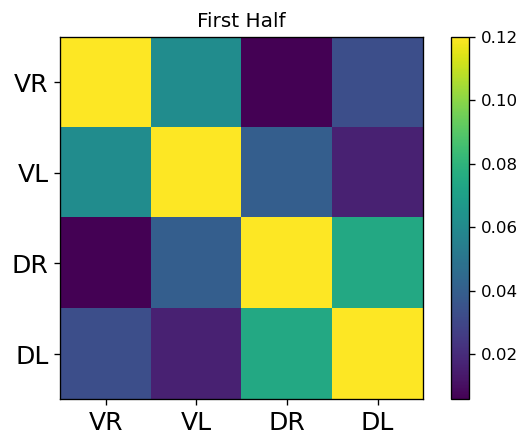

In [196]:
plt.figure(dpi=120)
plt.imshow(FFC1,vmax=0.12)
plt.colorbar()
plt.xticks([0,1,2,3],["VR","VL","DR","DL"] , fontsize=15)
plt.yticks([0,1,2,3],["VR","VL","DR","DL"], fontsize=15)
plt.title("First Half")

Text(0.5, 1.0, 'Second Half')

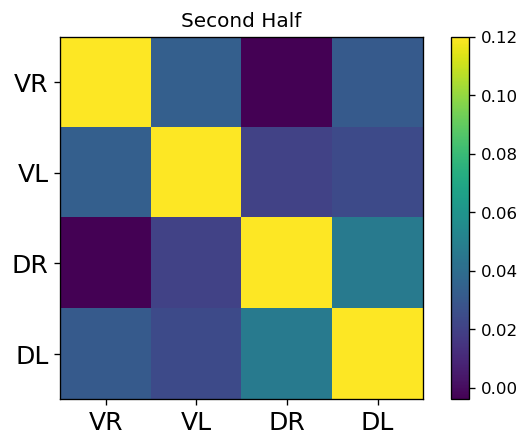

In [197]:
plt.figure(dpi=120)
plt.imshow(FFC2,vmax=0.12)
plt.colorbar()
plt.xticks([0,1,2,3],["VR","VL","DR","DL"] , fontsize=15)
plt.yticks([0,1,2,3],["VR","VL","DR","DL"], fontsize=15)
plt.title("Second Half")

#### Test with last preprocessing

In [118]:
def xy_corr_from_df(df):
    
    x = df[df.Half=="H1"].Corr.values
    y = df[df.Half=="H2"].Corr.values
    
    return x,y

In [119]:
x, y = xy_corr_from_df(VV_df)

Text(0, 0.5, 'Second Half')

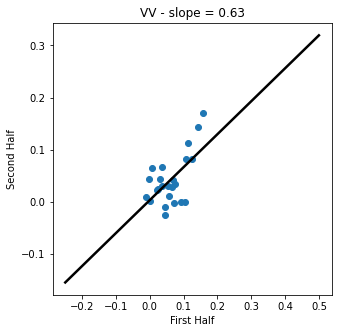

In [120]:
f, ax = plt.subplots(figsize = (5, 5))

ax.scatter(x,y)
b, a = np.polyfit(x, y, deg=1)
xseq = np.linspace(-0.25, 0.5, num=len(x))
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)
ax.set_title("VV - slope = %.2f" %b)
ax.set_xlabel("First Half")
ax.set_ylabel("Second Half")

In [121]:
ICC_VV_vals = np.zeros(len(options_to_consider))
ICC_DD_vals = np.zeros(len(options_to_consider))
ICC_Bw_vals = np.zeros(len(options_to_consider))
ICC_Wh_vals = np.zeros(len(options_to_consider))

# ICC_VV_std = np.zeros(len(options_to_consider))
# ICC_DD_std = np.zeros(len(options_to_consider))
# ICC_Bw_std = np.zeros(len(options_to_consider))
# ICC_Wh_std = np.zeros(len(options_to_consider))

ICC_VV_err  = []
ICC_DD_err  = []
ICC_Bw_err  = []
ICC_Wh_err  = []

for i,o in enumerate(options_to_consider):
    ICC_VV_vals[i] = ICC_dict[o]['VV']["ICC"]
    ICC_VV_err.append(ICC_dict[o]["VV"]["CI"])
    ICC_DD_vals[i] = ICC_dict[o]['DD']["ICC"]
    ICC_DD_err.append(ICC_dict[o]["DD"]["CI"])
    ICC_Bw_vals[i] = ICC_dict[o]['Bw']["ICC"]
    ICC_Bw_err.append(ICC_dict[o]["Bw"]["CI"])
    ICC_Wh_vals[i] = ICC_dict[o]['Wh']["ICC"]
    ICC_Wh_err.append(ICC_dict[o]["Wh"]["CI"])

#     ICC_VV_std[i] = np.diff(ICC_dict[o]['VV']['CI'])[0]/2
#     ICC_DD_std[i] = np.diff(ICC_dict[o]['DD']['CI'])[0]/2
#     ICC_Bw_std[i] = np.diff(ICC_dict[o]['Bw']['CI'])[0]/2
#     ICC_Wh_std[i] = np.diff(ICC_dict[o]['Wh']['CI'])[0]/2

In [122]:
ICC_VV_vals

array([0.7691867 , 0.71957987, 0.72061856, 0.56770275, 0.59796715,
       0.7271689 , 0.56822745, 0.65140131, 0.65436691, 0.62654466,
       0.62485207, 0.57173082])

In [123]:
ICC_DD_vals

array([0.89577606, 0.75491044, 0.78149516, 0.7195961 , 0.72670719,
       0.77894586, 0.72848122, 0.73919558, 0.70501954, 0.74619994,
       0.70686866, 0.62786578])

In [124]:
ICC_Bw_vals

array([0.89089249, 0.80801169, 0.75922978, 0.54877388, 0.58395805,
       0.7968622 , 0.73718977, 0.74392681, 0.74328882, 0.73918101,
       0.73226818, 0.65325588])

In [125]:
ICC_Wh_vals

array([0.85569317, 0.61281027, 0.54172488, 0.15996546, 0.10512796,
       0.64272441, 0.58904674, 0.48936106, 0.47239293, 0.4314621 ,
       0.41427951, 0.13414343])

In [128]:
ICC_VV_vals = np.zeros(len(options_to_consider))
ICC_DD_vals = np.zeros(len(options_to_consider))
ICC_Bw_vals = np.zeros(len(options_to_consider))
ICC_Wh_vals = np.zeros(len(options_to_consider))

# ICC_VV_std = np.zeros(len(options_to_consider))
# ICC_DD_std = np.zeros(len(options_to_consider))
# ICC_Bw_std = np.zeros(len(options_to_consider))
# ICC_Wh_std = np.zeros(len(options_to_consider))

ICC_VV_err  = []
ICC_DD_err  = []
ICC_Bw_err  = []
ICC_Wh_err  = []

for i,o in enumerate(options_to_consider):
    ICC_VV_vals[i] = ICC_dict[o]['VV']["ICC"]
    ICC_VV_err.append(ICC_dict[o]["VV"]["CI"])
    ICC_DD_vals[i] = ICC_dict[o]['DD']["ICC"]
    ICC_DD_err.append(ICC_dict[o]["DD"]["CI"])
    ICC_Bw_vals[i] = ICC_dict[o]['Bw']["ICC"]
    ICC_Bw_err.append(ICC_dict[o]["Bw"]["CI"])
    ICC_Wh_vals[i] = ICC_dict[o]['Wh']["ICC"]
    ICC_Wh_err.append(ICC_dict[o]["Wh"]["CI"])

#     ICC_VV_std[i] = np.diff(ICC_dict[o]['VV']['CI'])[0]/2
#     ICC_DD_std[i] = np.diff(ICC_dict[o]['DD']['CI'])[0]/2
#     ICC_Bw_std[i] = np.diff(ICC_dict[o]['Bw']['CI'])[0]/2
#     ICC_Wh_std[i] = np.diff(ICC_dict[o]['Wh']['CI'])[0]/2

In [129]:
# plot the ICC_dict
def plot_ICC(ICC_vals, ICC_errors,tempfilt, ROI):
    
    labels_options = []
    for o in options_to_consider:
        name,_ = get_mfmri_den_details(o)
        labels_options.append(name)
        
    # prepare error bars
    lowerbounds = []
    upperbounds = []
    for i in range(len(labels_options)):
        lb = ICC_errors[i][0]        
        if lb < -0.1:
            lb = -0.1
        lowerbounds.append(ICC_vals[i]-lb)
        upperbounds.append(ICC_errors[i][1]-ICC_vals[i])
    
    # save data
    ICC_df = pd.DataFrame(np.vstack([ICC_vals,lowerbounds,upperbounds]).T, columns=["ICC","lowerbounds","upperbounds"])
    ICC_df.to_csv(f'Outputs_paper_data/{tempfilt}_{ROI}_ICC.csv')
    
#     fig = go.Figure()
#     fig.add_trace(go.Scatter(
#         x=labels_options, y=ICC_vals,
#         mode='markers'
#     ))
    
    
#     for i,lab in enumerate(labels_options):
#         fig.add_vline(x=i, y0=ICC_errors[i][0],y1=ICC_errors[i][1],ysizemode='pixel',yanchor="top")

    
    fig = go.Figure(data=go.Scatter(
        x=labels_options,
        y=ICC_vals,
        mode='markers',
        error_y=dict(
            type='data',
            symmetric=False,
            array=upperbounds,
            arrayminus=lowerbounds,
            color="grey")
        ))

    
#     fig.update_layout(
#         yaxis=dict(
#             range = [-1,1.5])
#     )

    fig.show()
#     fig.write_html(f"Outputs_paper_figures/{tempfilt}_ICC_{ROI}.html")
#     fig.write_image(f"Outputs_paper_figures/{tempfilt}_ICC_{ROI}.pdf")

In [130]:
plot_ICC(ICC_VV_vals,ICC_VV_err,tempfilt,'VV')

In [131]:
plot_ICC(ICC_DD_vals,ICC_DD_err,tempfilt,'DD')

In [132]:
plot_ICC(ICC_Bw_vals,ICC_Bw_err,tempfilt,'Bw')

In [133]:
plot_ICC(ICC_Wh_vals,ICC_Wh_err,tempfilt,'Wh')

# ICC on physiological data

In [134]:
from scipy.signal import medfilt, butter, hilbert, find_peaks

## Respiratory



In [135]:
resp_subs_1 = []
resp_subs_2 = []

for sub in subjects_paths:
    data = np.loadtxt(os.path.join(sub,'physio',sub.split('/')[-1]+'.txt'))
    first_trig = np.where(data[:,2] == 5)[0][0]
    resp = data[first_trig:,0]
    b,a = butter(1,[0.01,0.6],'bandpass',fs=100)
    resp = filtfilt(b,a,resp)
    resp = medfilt(resp,601)
    
    phase = np.angle(hilbert(resp))
    
    # find zero-crossing frequency of the cycles
    resp_subs_1.append(len(np.where(np.diff(np.sign(phase[:int(len(resp)/2)])))[0]))
    resp_subs_2.append(len(np.where(np.diff(np.sign(phase[int(len(resp)/2):])))[0]))
    

In [183]:
resp_subs_1

[154,
 133,
 210,
 226,
 402,
 119,
 72,
 138,
 122,
 102,
 188,
 186,
 168,
 132,
 237,
 154,
 212,
 202,
 217,
 187,
 280,
 191,
 54,
 175]

In [184]:
resp_subs_2

[150,
 123,
 200,
 206,
 382,
 51,
 116,
 160,
 90,
 144,
 212,
 156,
 144,
 130,
 215,
 194,
 218,
 162,
 225,
 103,
 250,
 145,
 64,
 163]

In [187]:
resp_df = pd.DataFrame({"Subjects": subnames, "Half": ["H1"]*len(subjects_paths), "Val": resp_subs_1})
resp_df = pd.concat([resp_df, pd.DataFrame({"Subjects": subnames, "Half": ["H2"]*len(subjects_paths), "Val": resp_subs_2})],ignore_index=True)
icc_df_resp = pg.intraclass_corr(resp_df,targets="Subjects", raters="Half", ratings="Val")

In [188]:
icc_df_resp

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.885828,16.517489,23,24,1.008859e-09,"[0.76, 0.95]"
1,ICC2,Single random raters,0.886242,17.641127,23,23,9.957982e-10,"[0.75, 0.95]"
2,ICC3,Single fixed raters,0.892710,17.641127,23,23,9.957982e-10,"[0.77, 0.95]"
3,ICC1k,Average raters absolute,0.939458,16.517489,23,24,1.008859e-09,"[0.86, 0.97]"
4,ICC2k,Average random raters,0.939691,17.641127,23,23,9.957982e-10,"[0.86, 0.97]"
5,ICC3k,Average fixed raters,0.943314,17.641127,23,23,9.957982e-10,"[0.87, 0.98]"


In [189]:
resp_both = np.vstack([resp_subs_1,resp_subs_2]).T
resp_icc = icc(resp_both)
resp_icc_ci = bootstrap_icc(resp_both,icc)
print(resp_icc, resp_icc_ci)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4575.33it/s]

0.8862420111045053 (0.6542154512019442, 0.9546882601976064)


### Cardiac

In [190]:
np.mean(np.diff(card[:xint(len(card)/2)]))

NameError: name 'card' is not defined

In [191]:
card_subs_1 = []
card_subs_2 = []

for sub in subjects_paths:
    card = np.loadtxt(os.path.join(sub,'physio',sub.split('/')[-1]+'_card_auto.txt'))
#     first_trig = np.where(data[:,2] == 5)[0][0]
#     card = data[first_trig:,1]
    
    card_subs_1.append(np.mean(np.diff(card[:int(len(card)/2)])))
    card_subs_2.append(np.mean(np.diff(card[int(len(card)/2):])))
    

In [192]:
card_df = pd.DataFrame({"Subjects": subnames, "Half": ["H1"]*len(subjects_paths), "Val": card_subs_1})
card_df = pd.concat([card_df, pd.DataFrame({"Subjects": subnames, "Half": ["H2"]*len(subjects_paths), "Val": card_subs_2})],ignore_index=True)
icc_df_card = pg.intraclass_corr(card_df,targets="Subjects", raters="Half", ratings="Val")

In [193]:
icc_df_card

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.945687,35.823717,23,24,1.883205e-13,"[0.88, 0.98]"
1,ICC2,Single random raters,0.945917,42.467211,23,23,7.992269e-14,"[0.86, 0.98]"
2,ICC3,Single fixed raters,0.953988,42.467211,23,23,7.992269e-14,"[0.9, 0.98]"
3,ICC1k,Average raters absolute,0.972086,35.823717,23,24,1.883205e-13,"[0.94, 0.99]"
4,ICC2k,Average random raters,0.972207,42.467211,23,23,7.992269e-14,"[0.93, 0.99]"
5,ICC3k,Average fixed raters,0.976452,42.467211,23,23,7.992269e-14,"[0.95, 0.99]"


In [194]:
card_icc

NameError: name 'card_icc' is not defined

In [195]:
card_both = np.vstack([card_subs_1,card_subs_2]).T
card_icc = icc(card_both)
card_icc_ci = bootstrap_icc(card_both,icc)
print(card_icc, card_icc_ci)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4503.94it/s]

0.945916938772086 (0.8767142370165283, 0.9742474375248706)


## On DVARS moco params

In [199]:
def abs2(x):
    return x.real**2 + x.imag**2

In [200]:
from scipy.signal import find_peaks

In [201]:
def periodicity(s,t):
    # s = signal
    # t = timevector
    L = len(t)
    Ts = np.mean(np.diff(t)) # sampling interval
    Fs = 1/Ts # Sampling Frequency
    Fn = Fs/2 # Nyquist Frequency
    FTs = np.fft.fft(s)/L # Normalised Fourier Transform
    Fv = np.linspace(0, 1, int(np.fix(L/2)+1))*Fn # % Frequency Vector
    Iv = np.arange(len(Fv)) # Index Vector

    # To calculate the period (the inverse of frequency ) of a signal:
    pks = find_peaks(abs(FTs[Iv]))
    Perd = 1./Fv[pks[0]]
    
    return Perd

In [202]:
time_acquisitions = np.arange(0,900,2.5)

In [203]:
np.fix(len(time_acquisitions)/2)+1

181.0

In [205]:
moco_subs_1 = []
moco_subs_2 = []

for sub in subjects_paths:
    moco = os.path.join(sub,'func/Moco/n_moco_params.tsv')
    df = pd.read_csv(moco,sep='\t' )
    X = df.X
    Y = df.Y
    
    #xy = (X+Y)/2
    XY = np.vstack([X,Y]).T
    FD = np.diff(XY,axis=0)
    xy = np.sum(np.abs(FD), 1)

        
    moco_subs_1.append(np.mean(xy[:int(len(xy)/2)]))
    moco_subs_2.append(np.mean(xy[int(len(xy)/2):-1]))

In [220]:
moco_df = pd.DataFrame({"Subjects": subnames, "Half": ["H1"]*len(subjects_paths), "Val": moco_subs_1})
moco_df = pd.concat([moco_df, pd.DataFrame({"Subjects": subnames, "Half": ["H2"]*len(subjects_paths), "Val": moco_subs_2})],ignore_index=True)
icc_df_moco = pg.intraclass_corr(moco_df,targets="Subjects", raters="Half", ratings="Val")

In [232]:
icc_df_moco

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.807556,9.392609,23,24,3.408398e-07,"[0.61, 0.91]"
1,ICC2,Single random raters,0.806940,9.091314,23,23,7.230247e-07,"[0.6, 0.91]"
2,ICC3,Single fixed raters,0.801810,9.091314,23,23,7.230247e-07,"[0.59, 0.91]"
3,ICC1k,Average raters absolute,0.893533,9.392609,23,24,3.408398e-07,"[0.76, 0.95]"
4,ICC2k,Average random raters,0.893156,9.091314,23,23,7.230247e-07,"[0.75, 0.95]"
5,ICC3k,Average fixed raters,0.890005,9.091314,23,23,7.230247e-07,"[0.75, 0.95]"


## On CSF regressors


In [209]:
from pathlib import Path

In [211]:
csf_subs_1 = []
csf_subs_2 = []

for sub in subjects_paths:
    file = Path(os.path.join(sub,'func/regressors_evlist_st_csfonly.txt')).read_text()[:-1]
    img = nib.load(file)
    f_img_data = img.get_fdata()
    tsignalslices = f_img_data.reshape([f_img_data.shape[-2], f_img_data.shape[-1]])
    
    csf_array = np.mean(tsignalslices, axis=0)
    csf_subs_1.append(np.std(csf_array[:int(len(csf_array)/2)]))
    csf_subs_2.append(np.std(csf_array[int(len(csf_array)/2):]))


In [230]:
csf_df = pd.DataFrame({"Subjects": subnames, "Half": ["H1"]*len(subjects_paths), "Val": csf_subs_1})
csf_df = pd.concat([csf_df, pd.DataFrame({"Subjects": subnames, "Half": ["H2"]*len(subjects_paths), "Val": csf_subs_2})],ignore_index=True)
csf_df_icc = pg.intraclass_corr(csf_df,targets="Subjects", raters="Half", ratings="Val")

In [231]:
csf_df_icc

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.865587,13.879508,23,24,6.387140e-09,"[0.72, 0.94]"
1,ICC2,Single random raters,0.866067,14.660784,23,23,6.654904e-09,"[0.72, 0.94]"
2,ICC3,Single fixed raters,0.872292,14.660784,23,23,6.654904e-09,"[0.73, 0.94]"
3,ICC1k,Average raters absolute,0.927951,13.879508,23,24,6.387140e-09,"[0.84, 0.97]"
4,ICC2k,Average random raters,0.928227,14.660784,23,23,6.654904e-09,"[0.83, 0.97]"
5,ICC3k,Average fixed raters,0.931791,14.660784,23,23,6.654904e-09,"[0.84, 0.97]"


In [215]:
np.mean(csf_array[:int(len(csf_array)/2)])

0.031595660532879065

In [217]:
csf_subs_1 = []
csf_subs_2 = []
csf_arrays = []
for sub in subjects_paths:
    file = Path(os.path.join(sub,'func/regressors_evlist_st_csfonly.txt')).read_text()[:-1]
    img = nib.load(file)
    f_img_data = img.get_fdata()
    tsignalslices = f_img_data.reshape([f_img_data.shape[-2], f_img_data.shape[-1]])
    
    csf_array = np.mean(tsignalslices, axis=0)
    
    fft1 = np.fft.rfft(csf_array[:int(len(csf_array)/2)])
    fft2 = np.fft.rfft(csf_array[int(len(csf_array)/2):])
    
    csf_subs_1.append(np.mean((np.abs(fft1) ** 2)/len(fft1)))
    csf_subs_2.append(np.mean((np.abs(fft2) ** 2)/len(fft2)))
    
#     csf_subs_1.append(np.mean(np.angle(fft1)))
#     csf_subs_2.append(np.mean(np.angle(fft2)))
    

In [218]:
csf_df = pd.DataFrame({"Subjects": subnames, "Half": ["H1"]*len(subjects_paths), "Val": csf_subs_1})
csf_df = pd.concat([csf_df, pd.DataFrame({"Subjects": subnames, "Half": ["H2"]*len(subjects_paths), "Val": csf_subs_2})],ignore_index=True)
csf_df_icc = pg.intraclass_corr(csf_df,targets="Subjects", raters="Half", ratings="Val")

In [219]:
csf_df_icc

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.865587,13.879508,23,24,6.387140e-09,"[0.72, 0.94]"
1,ICC2,Single random raters,0.866067,14.660784,23,23,6.654904e-09,"[0.72, 0.94]"
2,ICC3,Single fixed raters,0.872292,14.660784,23,23,6.654904e-09,"[0.73, 0.94]"
3,ICC1k,Average raters absolute,0.927951,13.879508,23,24,6.387140e-09,"[0.84, 0.97]"
4,ICC2k,Average random raters,0.928227,14.660784,23,23,6.654904e-09,"[0.83, 0.97]"
5,ICC3k,Average fixed raters,0.931791,14.660784,23,23,6.654904e-09,"[0.84, 0.97]"


# Supplementary Respiratory investigation

Correlate respiratory signals with the denoised resp fmri -- done in older version : correlation of 0.01 -> cloud of points spread